# Ecoli Case (K12, 4587) for RXNRecer

> author: Shizhenkun   
> email: zhenkun.shi@tib.cas.cn   
> date: 2025-05-19  


## 1. Import packages

In [1]:
import sys,os
sys.path.insert(0, os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(1,'../../')
sys.path.insert(1,'../../../')
sys.path.insert(1,'../methods/active-learning/')
from config import conf as cfg
from tools import uniprottool as uptool
from tools import  bioFunctionLib as bfl
import rxnrecer as production
from modules import commonfunction as cmfunc
from tqdm import tqdm
import ast
import re
from pandarallel import pandarallel # 导入pandaralle
pandarallel.initialize(progress_bar=False)
from tkinter import _flatten
import json
from tools import btools
from evaluation import evTools
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn3

FIRST_TIME_RUN = False # For the initial run, please set this flag to True. This will allow the program to download data from UniProt and RHEA, which may take longer depending on your internet speed.

%load_ext autoreload
%autoreload 2

INFO: Pandarallel will run on 192 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## 2. Obtain ecoli case data from public web sites

In [2]:
if FIRST_TIME_RUN:
    api_url =f'https://rest.uniprot.org/uniprotkb/search?compressed=false&format=tsv&query=(ecoli) and (model_organism:83333)&fields=accession,reviewed,protein_name,gene_names,gene_oln,organism_name,length,ec,rhea,sequence&size=500'
    case_ecoli = uptool.get_batch_data_from_uniprot_rest_api(url=api_url)    
    case_ecoli = pd.DataFrame(case_ecoli, columns=['uniprot_id','reviewed','protein_name','gene_names', 'gene_oln','organism_name','length','ec','reaction_id','seq'])
    case_ecoli = case_ecoli.replace('','-')
    
    case_ecoli.reaction_id = case_ecoli.reaction_id.apply(lambda x: (cfg.SPLITER).join(x.split(' ')))
    case_ecoli.ec = case_ecoli.ec.apply(lambda x: (cfg.SPLITER).join(x.split('; ')))
    
    #从fasta 读取4587数据
    records_from_k12_fasta = bfl.fasta_to_dataframe('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/case/ecoli/uniprotkb_k12_AND_model_organism_83333_2024_12_16.fasta').rename(columns={'uniprot_id':'input_id'})
    records_from_k12_fasta['uniprot_id'] = records_from_k12_fasta.input_id.apply(lambda x: x.split('|')[1])
    try2_uniprot_ids = records_from_k12_fasta[~records_from_k12_fasta.uniprot_id.isin(case_ecoli.uniprot_id)].uniprot_id.to_list()

    # 补充额外的数据
    try2_uniprot_res = []
    for ids in tqdm(try2_uniprot_ids):
        api_url = f'https://rest.uniprot.org/uniprotkb/search?query=accession:{ids}&format=tsv&fields=accession,reviewed,protein_name,gene_names,gene_oln,organism_name,length,ec,rhea,sequence&compressed=false'
        case_ecoli = uptool.get_one_record_from_uniprot_rest_api(url=api_url)
        try:
            try2_uniprot_res = try2_uniprot_res + [case_ecoli.split('\n')[1].split('\t')]
        except Exception as e:
            print(e)
            
    try2_uniprot_res = pd.DataFrame(try2_uniprot_res, columns=['uniprot_id','reviewed','protein_name','gene_names', 'gene_oln','organism_name','length','ec','reaction_id','seq'])
    case_ecoli = pd.concat([case_ecoli,try2_uniprot_res]).reset_index(drop=True)
    case_ecoli.reaction_id = case_ecoli.reaction_id.replace('','-')
    case_ecoli.to_feather(cfg.FILE_DS_CASE_ECOLI)    #保存文件
    
    ### 下载bigg模型文件和IML1515 gene
    ! wget -c http://bigg.ucsd.edu/static/models/iML1515.json
    ! wget -c http://bigg.ucsd.edu/static/namespace/bigg_models_reactions.txt
    ! wget -c http://bigg.ucsd.edu/static/namespace/universal_model.json
else:
    case_ecoli = pd.read_feather(cfg.FILE_DS_CASE_ECOLI)
    print(f'Records in uniprot-rhea relation:\t{len(case_ecoli)}')

Records in uniprot-rhea relation:	4587


In [9]:
case_ecoli

,uniprot_id,reviewed,protein_name,gene_names,gene_oln,organism_name,length,ec_in_uniprot,rxn_id_in_uniprot,seq,rxn_equation_in_uniprot
0,Q46901,reviewed,CRISPR system Cascade subunit CasA (CRISPR typ...,casA cse1 ygcL b2760 JW2730,b2760 JW2730,Escherichia coli (strain K12),502,-,-,MNLLIDNWIPVRPRNGGKVQIINLQSLYCSRDQWRLSLPRDDMELA...,-
1,P77304,reviewed,Dipeptide and tripeptide permease A,dtpA tppB ydgR b1634 JW1626,b1634 JW1626,Escherichia coli (strain K12),500,-,-,MSTANQKPTESVSLNAFKQPKAFYLIFSIELWERFGYYGLQGIMAV...,-
2,P36837,reviewed,Dipeptide and tripeptide permease B,dtpB yhiP b3496 JW3463,b3496 JW3463,Escherichia coli (strain K12),489,-,-,MNTTTPMGMLQQPRPFFMIFFVELWERFGYYGVQGVLAVFFVKQLG...,-
3,P75990,reviewed,Blue light- and temperature-regulated antirepr...,bluF blrp ycgF b1163 JW1150,b1163 JW1150,Escherichia coli (strain K12),403,-,-,MLTTLIYRSHIRDDEPVKKIEEMVSIANRRNMQSDVTGILLFNGSH...,-
4,P39276,reviewed,Dipeptide and tripeptide permease C (Dipeptide...,dtpC yjdL b4130 JW4091,b4130 JW4091,Escherichia coli (strain K12),485,-,-,MKTPSQPRAIYYIVAIQIWEYFSFYGMRALLILYLTHQLGFDDNHA...,-
...,...,...,...,...,...,...,...,...,...,...,...
4582,Q47556,unreviewed,Aspartate transcarbamoylase regulatory chain,pyrI,,Escherichia coli (strain K12),9,,-,MTHDNKLQV,-
4583,Q5H778,unreviewed,Putrescine importer,puuP,,Escherichia coli (strain K12),479,,-,LISGRHDRKPYYAGEAAIMAINSPLNIAAQPGKTRLRKSLKLWQVV...,-
4584,Q7DFV4,reviewed,Putative uncharacterized protein YmdE,ymdE b1028,b1028,Escherichia coli (strain K12),107,,-,MEDGVQAMRDYLAGLDIASPEHQVLMNVTAKSEVAPSIIKENLSLH...,-
4585,Q9F5L1,unreviewed,Antiterminator BglG,bglG,,Escherichia coli (strain K12),22,,-,MNMQITKILNNNVVVVIDDQQR,-


In [3]:
num_reviewed = len(case_ecoli[case_ecoli.reviewed=="reviewed"])
num_reviewed_with_rxn = len(case_ecoli[(case_ecoli.reviewed=="reviewed") & (case_ecoli.reaction_id!="-")])
num_reviewed_without_rxn = len(case_ecoli[(case_ecoli.reviewed=="reviewed") & (case_ecoli.reaction_id=="-")])

num_unreviewed = len(case_ecoli[case_ecoli.reviewed=="unreviewed"])
num_unreviewed_with_rxn = len(case_ecoli[(case_ecoli.reviewed=="unreviewed")&(case_ecoli.reaction_id!="-")])
num_unreviewed_without_rxn = len(case_ecoli[(case_ecoli.reviewed=="unreviewed")&(case_ecoli.reaction_id=="-")])

print(f'Total Records in K12: {len(case_ecoli)}')
print(f'Reviewed: {num_reviewed}, with RXN: {num_reviewed_with_rxn}, without RXN:{num_reviewed_without_rxn}')
print(f'UnReviewed: {num_unreviewed}, with RXN:{num_unreviewed_with_rxn}, without RXN:{num_unreviewed_without_rxn}')

Total Records in K12: 4587
Reviewed: 4530, with RXN: 1388, without RXN:3142
UnReviewed: 57, with RXN:7, without RXN:50


## 3. Predcit with RXNRECer

In [4]:
# 从 JSON 文件加载反应编码字典

if FIRST_TIME_RUN:
    res =  production.step_by_step_prediction(input_data=case_ecoli[['uniprot_id', 'seq']],
                               output_file=None,
                               output_format='tsv',
                               getEquation=False,
                               Ensemble=True,
                               batch_size=100)

    RXNs = pd.read_feather(cfg.FILE_DS_RHEA_REACTIONS)
    res['equations']=res.RXNRECer.apply(lambda x: RXNs[RXNs.reaction_id.isin(x.split(cfg.SPLITER))].equation.to_list() if x!='-' else '-')
    res['equations_chebi']=res.RXNRECer.apply(lambda x: RXNs[RXNs.reaction_id.isin(x.split(cfg.SPLITER))].equation_chebi.to_list() if x!='-' else '-')
    res.to_pickle(f'{cfg.TEMP_DIR}case_ecoli_rxnrecer_inte_20250520-afternoon.pkl')
    
else:
    res = pd.read_pickle(f'{cfg.TEMP_DIR}case_ecoli_rxnrecer_inte_20250520-afternoon.pkl')

num_protein_with_rxn = len(res[res.RXNRECer!='-'])
num_protein_without_rxn = len(res[res.RXNRECer=='-'])

print(f'Predicted Protein with RXN: {num_protein_with_rxn}')
print(f'Predicted Protein without RXN: {num_protein_without_rxn}')

res.head(2)

Predicted Protein with RXN: 1604
Predicted Protein without RXN: 2983


,input_id,RXNRECer,RXNRECer_with_prob,equations,equations_chebi
0,Q46901,-,{'-': 1.0},-,-
1,P77304,-,{'-': 1.0},-,-


## 4. Add gene data

In [5]:
def get_bids(str_gene_name):
    items = str_gene_name.split()

    # 提取以 'b' 开头的ID
    b_ids = [item for item in items if re.match(r'^b\d+$', item)]
    
    if len(b_ids) > 0:
        return b_ids[0]
    else: 
        return '-'
    
def get_rhea_equ_by_rheaid(rheaid, rxn_rhea):
    if rheaid=='-':
        return '-'
    else:
        rhea_ids = rheaid.split(cfg.SPLITER)
        rhea_ids = rxn_rhea[rxn_rhea.reaction_id.isin(rhea_ids)].equation.tolist()
        return rhea_ids

# RHEA 反应
rxn_rhea =pd.read_feather(cfg.FILE_RHEA_REACTION)
    
case_ecoli = pd.read_feather(cfg.FILE_DS_CASE_ECOLI).rename(columns={"reaction_id": "rxn_id_in_uniprot", 'ec': 'ec_in_uniprot'})
case_ecoli['rxn_equation_in_uniprot'] =case_ecoli.rxn_id_in_uniprot.apply(lambda x:  get_rhea_equ_by_rheaid(x, rxn_rhea))

case_ecoli_rxnrecer = pd.read_pickle(f'{cfg.TEMP_DIR}case_ecoli_rxnrecer_inte_20250520-afternoon.pkl').rename(columns={"equations": "ECRECer_equations", 'equations_chebi': 'ECRECer_equations_chebi'})

case_ecoli_res = case_ecoli.merge(case_ecoli_rxnrecer.rename(columns={'input_id':'uniprot_id'}), on='uniprot_id', how='left')
case_ecoli_res['gene_id_bigg']=case_ecoli_res.gene_names.apply(lambda x: get_bids(str_gene_name=x))
case_ecoli_res = case_ecoli_res[["uniprot_id", "protein_name", "reviewed","ec_in_uniprot",'rxn_id_in_uniprot','rxn_equation_in_uniprot',"gene_id_bigg",     "RXNRECer", "RXNRECer_with_prob","ECRECer_equations"]]    
case_ecoli_res.to_csv('case_ecoli_res.tsv', sep='\t',index=False)

case_ecoli_res.head(2)

,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,rxn_equation_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,ECRECer_equations
0,Q46901,CRISPR system Cascade subunit CasA (CRISPR typ...,reviewed,-,-,-,b2760,-,{'-': 1.0},-
1,P77304,Dipeptide and tripeptide permease A,reviewed,-,-,-,b1634,-,{'-': 1.0},-


## 5. 增加各种标签

### 5.1 增加是否在训练集中出现

In [6]:
ds_train = pd.read_feather(cfg.FILE_DS_TRAIN)
case_ecoli_res['protein_in_train'] = case_ecoli_res.uniprot_id.parallel_apply(lambda x: True if len(ds_train[ds_train.uniprot_id == x])>0 else False)
case_ecoli_res = case_ecoli_res.rename(columns={'reaction_id': 'rxn_id_in_uniprot'})
num_predicted_rxns_in_train = len(case_ecoli_res[(case_ecoli_res.protein_in_train)&(case_ecoli_res.RXNRECer!='-')])
num_predicted_rxns_not_in_train = len(case_ecoli_res[(~case_ecoli_res.protein_in_train)&(case_ecoli_res.RXNRECer!='-')])

print(f'训练集中出现的，预测出反应的：{num_predicted_rxns_in_train}')
print(f'训练集中未出现的，预测出反应的：{num_predicted_rxns_not_in_train}')

训练集中出现的，预测出反应的：1379
训练集中未出现的，预测出反应的：225


### 5.2  添加biggid

In [7]:
# 从 JSON 文件加载反应编码字典
with  open(f'{cfg.DIR_DICT}dict_rheaid2biggid.json', 'r') as json_file:
    dict_rheaid2biggid = json.load(json_file)
    print(f'加载rheaid2biggid字典完成，共有 {len(dict_rheaid2biggid)} 个键值对。')  # 打印加载的数据
    
case_ecoli_res['RXNRECer_in_biggid'] = case_ecoli_res.RXNRECer.parallel_apply(
    lambda x: list(set(
        item
        for rhea_id in (x.split(';') if ';' in x else [x])
        for item in dict_rheaid2biggid.get(rhea_id, []))
    )
)

加载rheaid2biggid字典完成，共有 7376 个键值对。


### 5.3 补充添加bigg 反应

In [37]:
def get_bigg_equ(bigg_id, rxn_bigg):
    if len(bigg_id)<1:
        return '-'
    res = [rxn_bigg[rxn_bigg.bigg_id == item].reaction_string.tolist() for item in bigg_id]
    return res

rxn_bigg = pd.read_csv('bigg_models_reactions.txt', sep='\t')

case_ecoli_res['ECRECER_rhea2bigg_equations'] = case_ecoli_res.RXNRECer_in_biggid.parallel_apply(lambda x: get_bigg_equ(x, rxn_bigg))
case_ecoli_res[case_ecoli_res.RXNRECer!='-'].head(2)

,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,rxn_equation_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,ECRECer_equations,protein_in_train,RXNRECer_in_biggid,ECRECER_rhea2bigg_equations
10,P03960,Potassium-transporting ATPase ATP-binding subu...,reviewed,7.2.2.6,RHEA:16777,[ATP + H2O + K(+)(out) = ADP + H(+) + K(+)(in)...,b0697,RHEA:16777,{'RHEA:16777': 1.0},[ATP + H2O + K(+)(out) = ADP + H(+) + K(+)(in)...,True,"[Kabcpp, HKtpp, HKt, Kabc]",[[atp_c + h2o_c + k_p <-> adp_c + h_c + k_c + ...
13,P0A9P0,Dihydrolipoyl dehydrogenase (EC 1.8.1.4) (Dihy...,reviewed,1.8.1.4,RHEA:15045,[N(6)-[(R)-dihydrolipoyl]-L-lysyl-[protein] + ...,b0116,RHEA:15045,{'RHEA:15045': 1.0},[N(6)-[(R)-dihydrolipoyl]-L-lysyl-[protein] + ...,True,[],-


In [38]:
manual_inspect_20250609= case_ecoli_res.merge(case_ecoli[['uniprot_id','gene_names']],on='uniprot_id',how='left').rename(columns={'ECRECer_equations':'RXNRECer_equations'})

In [39]:
# 自定义排序键：提取字母和数字
# 自定义排序函数
def sort_key(val):
    import re
    match = re.match(r'([a-zA-Z]+)?(\d+)?', str(val))
    if match:
        prefix = match.group(1) or ''
        number = int(match.group(2)) if match.group(2) else float('inf')
        return (prefix, number)
    return ('', float('inf'))

# 排序


In [40]:
manual_inspect_20250609 = manual_inspect_20250609.sort_values(by='gene_id_bigg', key=lambda col: col.map(sort_key)).reset_index(drop=True)
manual_inspect_20250609['gene_names'] = manual_inspect_20250609['gene_names'].apply(lambda x:x.split(' ')[0])
manual_inspect_20250609.head(3)

,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,rxn_equation_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,RXNRECer_equations,protein_in_train,RXNRECer_in_biggid,ECRECER_rhea2bigg_equations,gene_names
0,Q9JMS5,Uncharacterized protein YuaO,reviewed,-,-,-,-,-,{'-': 1.0},-,True,[],-,yuaO
1,Q1PI83,Adenylate kinase (EC 2.7.4.3),unreviewed,2.7.4.3,RHEA:12973,[AMP + ATP = 2 ADP],-,RHEA:12973,{'RHEA:12973': 0.999989},[AMP + ATP = 2 ADP],False,"[ADK1m, ATAMh, ADK1]","[[amp_m + atp_m <-> 2.0 adp_m], [amp_h + atp_h...",adk
2,P18006,Protein TrbI,reviewed,-,-,-,-,-,{'-': 1.0},-,True,[],-,trbI


In [45]:
manual_inspect_20250609 = manual_inspect_20250609[['uniprot_id','gene_id_bigg','gene_names','rxn_equation_in_uniprot','RXNRECer_equations','protein_in_train']].reset_index(drop=True)

In [46]:
manual_inspect_20250609.to_excel('./res/manual_inspect_20250609.xlsx', index=False)

### 5.4  对比IML1515 gene

In [9]:
with open('iML1515.json', 'r', encoding='utf-8') as f:
    iml1515 = json.load(f)
    
iml1515_gene_ids = [gene['id'] for gene in iml1515['genes']]
print(f'Gene ids in iML1515: {len(iml1515_gene_ids)}')

# 添加Gene信息
case_ecoli_res['gene_in_iml1515'] = case_ecoli_res.gene_id_bigg.parallel_apply(lambda x: x in iml1515_gene_ids)


rxn_iml1515 = pd.DataFrame(iml1515['reactions'])
rxn_iml1515['gene']=rxn_iml1515.gene_reaction_rule.apply(lambda x: x.split(' or '))

# 构造 biggid2rheaid 字典
biggid2gene = rxn_iml1515.set_index('id')['gene'].to_dict()

# 构造 gene2biggid 字典
gene2biggid = {}
for bigg_id, gene in biggid2gene.items():
    for rhea_id in gene:
        gene2biggid.setdefault(rhea_id, []).append(bigg_id)


rxn_iml1515.head(3)

Gene ids in iML1515: 1516


,id,name,metabolites,lower_bound,upper_bound,gene_reaction_rule,subsystem,notes,annotation,objective_coefficient,gene
0,CYTDK2,Cytidine kinase (GTP),"{'cmp_c': 1.0, 'cytd_c': -1.0, 'gdp_c': 1.0, '...",0.0,1000.0,b2066,Nucleotide Salvage Pathway,{'original_bigg_ids': ['CYTDK2']},"{'bigg.reaction': ['CYTDK2'], 'biocyc': ['META...",NaN,[b2066]
1,XPPT,Xanthine phosphoribosyltransferase,"{'ppi_c': 1.0, 'prpp_c': -1.0, 'xan_c': -1.0, ...",0.0,1000.0,b0238,Nucleotide Salvage Pathway,{'original_bigg_ids': ['XPPT']},"{'bigg.reaction': ['XPPT'], 'biocyc': ['META:X...",NaN,[b0238]
2,HXPRT,Hypoxanthine phosphoribosyltransferase (Hypoxa...,"{'hxan_c': -1.0, 'imp_c': 1.0, 'ppi_c': 1.0, '...",0.0,1000.0,b0238 or b0125,Nucleotide Salvage Pathway,{'original_bigg_ids': ['HXPRT']},"{'bigg.reaction': ['HXPRT'], 'biocyc': ['META:...",NaN,"[b0238, b0125]"


In [10]:
def get_gene_bigg_rxn(gene_id, dict_gene2biggid):
    if gene_id=='-':
        return '-'
    else:
        rxn_ids = dict_gene2biggid.get(gene_id)
        if rxn_ids==None:
            
            # 遍历并查找包含 gene_id 的键的值
            matching_values = [(key,get_bigg_equ(value, rxn_bigg)) for key, value in dict_gene2biggid.items() if gene_id in key]

            if matching_values:
                # print(f'{gene_id} in key {matching_values}')
                # print(list(matching_values))
                return list(matching_values)
            
            return '-'
        else:
            rxns = get_bigg_equ(rxn_ids, rxn_bigg)
        
        return rxns
    
case_ecoli_res['gene_bigg_rxn'] = case_ecoli_res.gene_id_bigg.parallel_apply(lambda x: get_gene_bigg_rxn(x, gene2biggid))

In [11]:
case_ecoli_res[case_ecoli_res.gene_in_iml1515]

,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,rxn_equation_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,ECRECer_equations,protein_in_train,RXNRECer_in_biggid,ECRECER_rhea2bigg_equations,gene_in_iml1515,gene_bigg_rxn
1,P77304,Dipeptide and tripeptide permease A,reviewed,-,-,-,b1634,-,{'-': 1.0},-,True,[],-,True,"[[LalaLglu_p + h_p <-> LalaLglu_c + h_c], [Lal..."
2,P36837,Dipeptide and tripeptide permease B,reviewed,-,-,-,b3496,-,{'-': 1.0},-,True,[],-,True,"[[LalaLglu_p + h_p <-> LalaLglu_c + h_c], [Lal..."
4,P39276,Dipeptide and tripeptide permease C (Dipeptide...,reviewed,-,-,-,b4130,-,{'-': 1.0},-,True,[],-,True,"[[ala__L_p + h_p <-> ala__L_c + h_c], [LalaLgl..."
9,P03961,Potassium-transporting ATPase KdpC subunit (AT...,reviewed,-,-,-,b0696,-,{'-': 1.0},-,True,[],-,True,"[((b0698 and b0697 and b0696), [['atp_c + h2o_..."
10,P03960,Potassium-transporting ATPase ATP-binding subu...,reviewed,7.2.2.6,RHEA:16777,[ATP + H2O + K(+)(out) = ADP + H(+) + K(+)(in)...,b0697,RHEA:16777,{'RHEA:16777': 1.0},[ATP + H2O + K(+)(out) = ADP + H(+) + K(+)(in)...,True,"[HKt, Kabc, HKtpp, Kabcpp]",[[atp_c + k_e + h2o_c <-> k_c + h_e + adp_c + ...,True,"[((b0698 and b0697 and b0696), [['atp_c + h2o_..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3837,P0DP69,Putative cryptic phosphonate transport system ...,reviewed,-,-,-,b4104,-,{'-': 1.0},-,True,[],-,True,"[(b4104 and b4105 and b4106, [['h2o_c + atp_c ..."
4231,P77252,Uncharacterized protein YkgE,reviewed,-,-,-,b0306,-,{'-': 1.0},-,True,[],-,True,"[((b0306 and b0308 and b0307), [['lac__L_c + m..."
4324,P77453,Hydrogenase-4 component J (EC 1.-.-.-),reviewed,1.-.-.-,-,-,b2490,-,{'-': 0.999996},-,False,[],-,True,[((b4079 and (b2489 and b2487 and b2485 and b2...
4403,P37627,Uncharacterized protein YhiJ,reviewed,-,-,-,b3488,-,{'-': 1.0},-,True,[],-,True,[[inost_c + o2_c <-> glcur_c + h_c + h2o_c]]


## 6. 计算预测性能指标

In [12]:
with open(cfg.FILE_DS_DICT_RXN2ID, "r") as json_file:
    raw_dict_rxn2id = json.load(json_file)
    dict_rxn2id = {k: int(v) for k, v in raw_dict_rxn2id.items()}

print(f'加载反应编码字典完成，共有 {len(dict_rxn2id)} 个反应。')

# 添加标签
case_ecoli_res['lb_rxn_groundtruth'] = case_ecoli_res.rxn_id_in_uniprot.parallel_apply(lambda x: btools.make_label(reaction_id=x, rxn_label_dict=dict_rxn2id))
case_ecoli_res['lb_rxn_ecrecer'] = case_ecoli_res.RXNRECer.parallel_apply(lambda x: btools.make_label(reaction_id=x, rxn_label_dict=dict_rxn2id))

# 添加预测筛选标签
case_ecoli_res['pred_uniprot_correct'] =case_ecoli_res.apply(lambda x: (x.lb_rxn_groundtruth==x.lb_rxn_ecrecer).all(), axis=1)
#计算评价指标
avg_types =['macro', 'micro', 'samples', 'weighted']
eva_res = [evTools.calculate_metrics(eva_df=case_ecoli_res, ground_truth_col='lb_rxn_groundtruth', pred_col='lb_rxn_ecrecer', eva_name='ECRecer',avg_method=avg_type) for avg_type in avg_types]

metrics = pd.concat(eva_res, axis=0).reset_index(drop=True)
metrics
# metrics[metrics.avgType=='micro']

加载反应编码字典完成，共有 10479 个反应。


,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType
0,ECRecer,0.919119,0.957259,0.996366,0.958292,macro
1,ECRecer,0.919119,0.859172,0.948970,0.901841,micro
2,ECRecer,0.919119,0.938104,0.949097,0.940404,samples
3,ECRecer,0.919119,0.958840,0.948970,0.943471,weighted


In [13]:
#计算[酶部分]评价指标
avg_types =['macro', 'micro', 'samples', 'weighted']
eva_res = [evTools.calculate_metrics(eva_df=case_ecoli_res[case_ecoli_res.rxn_id_in_uniprot!='-'].reset_index(drop=True), ground_truth_col='lb_rxn_groundtruth', pred_col='lb_rxn_ecrecer', eva_name='ECRecer',avg_method=avg_type) for avg_type in avg_types]

metrics = pd.concat(eva_res, axis=0).reset_index(drop=True)
# metrics[metrics.avgType=='micro']
metrics

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType
0,ECRecer,0.889606,0.990634,0.996373,0.988322,macro
1,ECRecer,0.889606,0.921622,0.974750,0.947442,micro
2,ECRecer,0.889606,0.952029,0.988178,0.959593,samples
3,ECRecer,0.889606,0.978931,0.974750,0.964974,weighted


In [14]:
#计算[非酶部分]评价指标
avg_types =['macro', 'micro', 'samples', 'weighted']
eva_res = [evTools.calculate_metrics(eva_df=case_ecoli_res[case_ecoli_res.rxn_id_in_uniprot=='-'].reset_index(drop=True), ground_truth_col='lb_rxn_groundtruth', pred_col='lb_rxn_ecrecer', eva_name='ECRecer',avg_method=avg_type) for avg_type in avg_types]

metrics = pd.concat(eva_res, axis=0).reset_index(drop=True)
# metrics[metrics.avgType=='micro']
metrics

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType
0,ECRecer,0.932018,0.953717,0.999994,0.953714,macro
1,ECRecer,0.932018,0.820916,0.932018,0.872946,micro
2,ECRecer,0.932018,0.932018,0.932018,0.932018,samples
3,ECRecer,0.932018,1.000000,0.932018,0.964813,weighted


In [15]:
#计算在训练集中出现的这一部分评价指标
avg_types =['macro', 'micro', 'samples', 'weighted']
eva_res = [evTools.calculate_metrics(eva_df=case_ecoli_res[case_ecoli_res.protein_in_train].reset_index(drop=True), ground_truth_col='lb_rxn_groundtruth', pred_col='lb_rxn_ecrecer', eva_name='ECRecer',avg_method=avg_type) for avg_type in avg_types]

metrics = pd.concat(eva_res, axis=0).reset_index(drop=True)
# metrics[metrics.avgType=='micro']
metrics

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType
0,ECRecer,0.961817,0.990873,0.996380,0.988581,macro
1,ECRecer,0.961817,0.964352,0.988738,0.976393,micro
2,ECRecer,0.961817,0.983549,0.995884,0.986182,samples
3,ECRecer,0.961817,0.989012,0.988738,0.983594,weighted


In [16]:
#计算在训练集中没出现的这一部分评价指标
avg_types =['macro', 'micro', 'samples', 'weighted']
eva_res = [evTools.calculate_metrics(eva_df=case_ecoli_res[case_ecoli_res.protein_in_train==False].reset_index(drop=True), ground_truth_col='lb_rxn_groundtruth', pred_col='lb_rxn_ecrecer', eva_name='ECRecer',avg_method=avg_type) for avg_type in avg_types]

metrics = pd.concat(eva_res, axis=0).reset_index(drop=True)
# metrics[metrics.avgType=='micro']
metrics

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType
0,ECRecer,0.624138,0.953860,0.999868,0.953858,macro
1,ECRecer,0.624138,0.361138,0.629060,0.458853,micro
2,ECRecer,0.624138,0.624138,0.625862,0.624138,samples
3,ECRecer,0.624138,0.990418,0.629060,0.766781,weighted


In [17]:
num_not_in_train = len(case_ecoli_res[case_ecoli_res.protein_in_train==False].reset_index(drop=True))
print(f'不在训练集中的蛋白数量：{num_not_in_train}')
num_not_in_train_equ_uniprot = len(case_ecoli_res[(case_ecoli_res.protein_in_train==False)&(case_ecoli_res.pred_uniprot_correct)])
print(f'不在训练集中，与Uniprot当前结果一致的:{num_not_in_train_equ_uniprot}')
print('不一致的主要是RXNRECer预测的多， 如下：')
case_ecoli_res[
    (case_ecoli_res.protein_in_train == False) &
    (~case_ecoli_res.pred_uniprot_correct)
][[
    'uniprot_id',
    'protein_name',
    'reviewed',
    'ec_in_uniprot',
    'rxn_id_in_uniprot',
    'gene_id_bigg',
    'RXNRECer',
    'RXNRECer_with_prob',
    'ECRECer_equations',
    'protein_in_train'
]]

不在训练集中的蛋白数量：580
不在训练集中，与Uniprot当前结果一致的:362
不一致的主要是RXNRECer预测的多， 如下：


,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,ECRECer_equations,protein_in_train
45,P37595,Isoaspartyl peptidase (EC 3.4.19.5) (Beta-aspa...,reviewed,3.4.19.5,-,b0828,RHEA:21016,{'RHEA:21016': 0.997006},[H2O + L-asparagine = L-aspartate + NH4(+)],False
84,P17117,Oxygen-insensitive NADPH nitroreductase (EC 1....,reviewed,1.-.-.-,-,b0851,RHEA:21624,{'RHEA:21624': 0.991285},[FMNH2 + NADP(+) = FMN + 2 H(+) + NADPH],False
101,P23872,Acetyl esterase (EC 3.1.1.-) (EcE),reviewed,3.1.1.-,-,b0476,RHEA:35715;RHEA:35719;RHEA:25597;RHEA:12044;RH...,"{'RHEA:35715': 0.979672, 'RHEA:35719': 0.97967...",[5-enolpyruvoyl-6-hydroxy-2-succinyl-cyclohex-...,False
157,P0A8V0,Ribonuclease BN (RNase BN) (EC 3.1.-.-) (Ribon...,reviewed,3.1.-.-,-,b2268,RHEA:17665;RHEA:10748,"{'RHEA:17665': 0.975597, 'RHEA:10748': 0.405842}","[H(+) + hydrogencarbonate = CO2 + H2O, L-lysyl...",False
162,P75792,Sugar phosphatase YbiV (EC 3.1.3.23),reviewed,3.1.3.23,-,b0822,RHEA:25197,{'RHEA:25197': 0.995549},[5-amino-6-(5-phospho-D-ribitylamino)uracil + ...,False
...,...,...,...,...,...,...,...,...,...,...
4510,A0A0G3HVX2,Gamma-aminobutyrate aminotransferase,unreviewed,,-,-,RHEA:23352,{'RHEA:23352': 1.0},[2-oxoglutarate + 4-aminobutanoate = L-glutama...,False
4512,A0A0G3I6S6,Fructoselysine-6-kinase,unreviewed,,-,-,RHEA:28378,{'RHEA:28378': 1.0},[ATP + N(6)-(D-fructosyl)-L-lysine = ADP + H(+...,False
4536,B8YM76,Alkaline phosphatase,unreviewed,,-,-,RHEA:15017,{'RHEA:15017': 0.9966},[a phosphate monoester + H2O = an alcohol + ph...,False
4539,F2X7N5,Nitroreductase,unreviewed,,-,-,RHEA:17869;RHEA:17865,"{'RHEA:17869': 0.999926, 'RHEA:17865': 0.999926}","[5,6,7,8-tetrahydropteridine + NADP(+) = 6,7-d...",False


## 7. 添加ECRECer 预测的EC号

In [18]:
fasta_input = '/hpcfs/fhome/shizhenkun/codebase/RXNRECer/case/ecoli/uniprotkb_k12_AND_model_organism_83333_2024_12_16.fasta'
tsv_output = '/hpcfs/fhome/shizhenkun/codebase/RXNRECer/case/ecoli/res/ecoli_case_ecrecer_250103.tsv'

cmd =   f'singularity exec --nv /hpcfs/fpublic/container/singularity/app/ecrecer/ecrecer.sif python /ecrecer/production.py -i {fasta_input} -o {tsv_output} -mode h -topk 20'
print(f'Using ECRECer to predict reaction for {fasta_input} and save the result to {tsv_output}')

ecrecer = pd.read_csv(tsv_output, sep='\t').rename(columns={'dmlf_ec': 'ECRECER_pred_EC'})
ecrecer.insert(0, 'uniprot_id', ecrecer.input_id.apply(lambda x: x.split('|')[1]))
ecrecer.head(3)

Using ECRECer to predict reaction for /hpcfs/fhome/shizhenkun/codebase/RXNRECer/case/ecoli/uniprotkb_k12_AND_model_organism_83333_2024_12_16.fasta and save the result to /hpcfs/fhome/shizhenkun/codebase/RXNRECer/case/ecoli/res/ecoli_case_ecrecer_250103.tsv


,uniprot_id,input_id,dmlf_isEnzyme,dmlf_functions,ECRECER_pred_EC,dmlf_recomendations,blast_ec
0,P0AG67,sp|P0AG67|RS1_ECOLI,False,1,-,"[('3.1.13.1', 0.9999842047691345), ('3.1.-.-',...",-
1,P0A7U3,sp|P0A7U3|RS19_ECOLI,False,1,-,"[('1.6.5.3', 0.9476693868637085), ('1.6.5.11',...",-
2,P03813,sp|P03813|YGEA_ECOLI,True,1,5.1.1.10,"[('5.-.-.-', 0.4973388910293579), ('5.1.1.3', ...",5.1.1.10


In [19]:
# 补充EC对应的反应信息
rxn_db =pd.read_feather(cfg.FILE_DS_RHEA_REACTIONS)
rxn_db = rxn_db[['reaction_id', 'ec_number', 'equation_chebi_balanced', 'equation']].rename(columns={'equation_chebi_balanced': 'equation_chebi', 'equation': 'equation_text'})
rxn_db = rxn_db[~rxn_db.ec_number.isna()].reset_index(drop=True)

def get_rxn_via_ec(ecs, rxn_db):
    if ecs == '-':
        return '-'
    
    ec_arr = ecs.split(';')
    res = []
    for ec in ec_arr:
        res_row = rxn_db[rxn_db.ec_number.str.contains(ec)].equation_text.tolist()
        res = res + res_row
    return res

def get_ec_via_rxns(rxns, rxn_db):
    if rxns =='-':
        return '-'
    rxn_arr = rxns.split(';')
    res = []
    for rxn in rxn_arr:
        res_row = rxn_db[rxn_db.reaction_id==rxn].ec_number.tolist()
        res = res + res_row
    
    return res

#数反应个数
def get_rxn_nums(rxns):
    if rxns =='-':
        return 0
    rxn_arr = rxns.split(';')
    return len(rxn_arr)

ecrecer['RXN4ECRECER_pred_EC']=ecrecer.ECRECER_pred_EC.apply(lambda x: get_rxn_via_ec(x, rxn_db))

# 添加EC预测结果到case_ecoli_res
case_ecoli_res = case_ecoli_res.merge(ecrecer[['uniprot_id', 'ECRECER_pred_EC','RXN4ECRECER_pred_EC']], on='uniprot_id', how='left')

# 将RXNRECer_with_prob转化为单列
# case_ecoli_res['RXNRECer_prob'] =case_ecoli_res.RXNRECer_with_prob.apply(lambda x: max(eval(x).values()))
case_ecoli_res['RXNRECer_prob'] = case_ecoli_res['RXNRECer_with_prob'].apply(
    lambda x: max(ast.literal_eval(x).values()) if isinstance(x, str) else max(x.values())
)

# 将RXNRECer预测的反应补充EC号
case_ecoli_res['RXNRECerTrans2EC']=case_ecoli_res.RXNRECer.apply(lambda x: get_ec_via_rxns(x, rxn_db))

# 计算RXNRECer预测的反应个数
case_ecoli_res['RXN_NUM_RXNRECER']=case_ecoli_res.RXNRECer.apply(lambda x: get_rxn_nums(x))
case_ecoli_res['RXN_NUM_Uniprot']=case_ecoli_res.rxn_id_in_uniprot.apply(lambda x: get_rxn_nums(x))

## 8. 整理数据保存结果

In [20]:
savedf_sheet_full = case_ecoli_res.drop(columns=['lb_rxn_groundtruth', 'lb_rxn_ecrecer']).copy()

In [21]:
savedf = case_ecoli_res.drop(columns=['lb_rxn_groundtruth', 'lb_rxn_ecrecer']).copy()
savedf.to_excel('res/rxnrecer_pred_ecoli_20250520.xlsx', index=False)
savedf.head(3)

,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,rxn_equation_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,ECRECer_equations,...,ECRECER_rhea2bigg_equations,gene_in_iml1515,gene_bigg_rxn,pred_uniprot_correct,ECRECER_pred_EC,RXN4ECRECER_pred_EC,RXNRECer_prob,RXNRECerTrans2EC,RXN_NUM_RXNRECER,RXN_NUM_Uniprot
0,Q46901,CRISPR system Cascade subunit CasA (CRISPR typ...,reviewed,-,-,-,b2760,-,{'-': 1.0},-,...,-,False,-,True,-,-,1.0,-,0,0
1,P77304,Dipeptide and tripeptide permease A,reviewed,-,-,-,b1634,-,{'-': 1.0},-,...,-,True,"[[LalaLglu_p + h_p <-> LalaLglu_c + h_c], [Lal...",True,-,-,1.0,-,0,0
2,P36837,Dipeptide and tripeptide permease B,reviewed,-,-,-,b3496,-,{'-': 1.0},-,...,-,True,"[[LalaLglu_p + h_p <-> LalaLglu_c + h_c], [Lal...",True,-,-,1.0,-,0,0


In [ ]:
case_ecoli_res = pd.read_excel('res/rxnrecer_pred_ecoli_20250520.xlsx')
case_ecoli_res[case_ecoli_res.uniprot_id =='A0A1V1IGJ0']

In [11]:
case_ecoli_res[case_ecoli_res.uniprot_id =='A0A1V1IGJ0']

,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,rxn_equation_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,ECRECer_equations,...,ECRECER_rhea2bigg_equations,gene_in_iml1515,gene_bigg_rxn,pred_uniprot_correct,ECRECER_pred_EC,RXN4ECRECER_pred_EC,RXNRECer_prob,RXNRECerTrans2EC,RXN_NUM_RXNRECER,RXN_NUM_Uniprot
2990,A0A1V1IGJ0,Guanosine-inosine kinase (EC 2.7.1.73),unreviewed,2.7.1.73,RHEA:27710;RHEA:21140,"['ATP + guanosine = ADP + GMP + H(+)', 'ATP + ...",-,RHEA:27710;RHEA:21140,"{'RHEA:27710': 0.999939, 'RHEA:21140': 0.999939}","['ATP + guanosine = ADP + GMP + H(+)', 'ATP + ...",...,"[['ins_m + atp_m <-> h_m + imp_m + adp_m'], ['...",False,-,True,2.7.1.73,"['ATP + guanosine = ADP + GMP + H(+)', 'ATP + ...",0.999939,"['EC:2.7.1.73', 'EC:2.7.1.73']",2,2


In [22]:
case_data_in_train_with_rxn_equ_pred = case_ecoli_res[(case_ecoli_res.pred_uniprot_correct==True) &(case_ecoli_res.rxn_id_in_uniprot!='-') & (case_ecoli_res.protein_in_train)]
case_data_in_train_with_rxn_not_equ_pred = case_ecoli_res[(case_ecoli_res.pred_uniprot_correct==False) &(case_ecoli_res.rxn_id_in_uniprot!='-') & (case_ecoli_res.protein_in_train)]

print(f'在训练集中出现，但是预测结果与Uniprot中一致的数据：{len(case_data_in_train_with_rxn_equ_pred)} 条')
print(f'在训练集中出现，但是预测结果与Uniprot中不一致的数据：{len(case_data_in_train_with_rxn_not_equ_pred)} 条')
print(f'不一致的数据中，预测没有反应的：{len(case_data_in_train_with_rxn_not_equ_pred[case_data_in_train_with_rxn_not_equ_pred.RXNRECer=="-"])}条')
print(f'不一致的数据中，都有反应但不一致：{len(case_data_in_train_with_rxn_not_equ_pred[case_data_in_train_with_rxn_not_equ_pred.RXNRECer!="-"])}条 \n')


case_data_notin_train_with_rxn_equ_pred = case_ecoli_res[(case_ecoli_res.pred_uniprot_correct==True) &(case_ecoli_res.rxn_id_in_uniprot!='-') & (~case_ecoli_res.protein_in_train)]
case_data_notin_train_with_rxn_not_equ_pred = case_ecoli_res[(case_ecoli_res.pred_uniprot_correct==False) &(case_ecoli_res.rxn_id_in_uniprot=='-') & (~case_ecoli_res.protein_in_train)]
print(f'未在训练集中出现，但是预测结果与Uniprot中一致的数据：{len(case_data_notin_train_with_rxn_equ_pred)} 条')
print(f'未在训练集中出现，预测结果与Uniprot中不一致的数据：{len(case_data_notin_train_with_rxn_not_equ_pred)} 条')


在训练集中出现，但是预测结果与Uniprot中一致的数据：1233 条
在训练集中出现，但是预测结果与Uniprot中不一致的数据：152 条
不一致的数据中，预测没有反应的：7条
不一致的数据中，都有反应但不一致：145条 

未在训练集中出现，但是预测结果与Uniprot中一致的数据：8 条
未在训练集中出现，预测结果与Uniprot中不一致的数据：216 条


In [23]:
case_ecoli_res[(case_ecoli_res.pred_uniprot_correct==False) &(case_ecoli_res.rxn_id_in_uniprot!='-') & (~case_ecoli_res.protein_in_train)]

,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,rxn_equation_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,ECRECer_equations,...,gene_bigg_rxn,lb_rxn_groundtruth,lb_rxn_ecrecer,pred_uniprot_correct,ECRECER_pred_EC,RXN4ECRECER_pred_EC,RXNRECer_prob,RXNRECerTrans2EC,RXN_NUM_RXNRECER,RXN_NUM_Uniprot
356,P39353,"2,7-anhydro-N-acetylneuraminate hydratase (EC ...",reviewed,4.2.1.-,RHEA:78519;RHEA:78523,[],b4280,RHEA:37547;RHEA:16949,"{'RHEA:37547': 0.983304, 'RHEA:16949': 0.261042}",[D-glucose 6-phosphate + NAD(+) = 3-dehydro-D-...,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,1.-.-.-,[],0.983304,"[EC:1.1.1.361, EC:1.1.1.18]",2,2
518,P0DTT0,Large ribosomal subunit assembly factor BipA (...,reviewed,3.6.5.-,RHEA:19669,[GTP + H2O = GDP + H(+) + phosphate],b3871,-,{'-': 1.0},-,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,3.6.5.-,[],1.000000,-,0,1


In [24]:
print('预测与Uniprot中不一致，主要是多了')
case_data_in_train_with_rxn_not_equ_pred[case_data_in_train_with_rxn_not_equ_pred.RXNRECer!='-']

预测与Uniprot中不一致，主要是多了


,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,rxn_equation_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,ECRECer_equations,...,gene_bigg_rxn,lb_rxn_groundtruth,lb_rxn_ecrecer,pred_uniprot_correct,ECRECER_pred_EC,RXN4ECRECER_pred_EC,RXNRECer_prob,RXNRECerTrans2EC,RXN_NUM_RXNRECER,RXN_NUM_Uniprot
17,P76251,D-malate dehydrogenase [decarboxylating] (EC 1...,reviewed,1.1.1.83,RHEA:18365,[(R)-malate + NAD(+) = CO2 + NADH + pyruvate],b1800,RHEA:18365;RHEA:13317,"{'RHEA:18365': 1.0, 'RHEA:13317': 0.7777}","[(2R,3R)-tartrate + H(+) = (R)-glycerate + CO2...",...,[[3c2hmp_c + nad_c <-> 3c4mop_c + h_c + nadh_c...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,1.1.1.83,[(R)-malate + NAD(+) = CO2 + NADH + pyruvate],1.0,"[EC:1.1.1.83, EC:4.1.1.73]",2,1
28,P31658,Protein/nucleic acid deglycase 1 (EC 3.1.2.-) ...,reviewed,3.1.2.-;3.5.1.-;3.5.1.124;4.2.1.130,RHEA:27754;RHEA:49548;RHEA:49552;RHEA:49556;RH...,"[H2O + methylglyoxal = (R)-lactate + H(+), H2O...",b1967,RHEA:57192;RHEA:57252;RHEA:57188;RHEA:57196;RH...,"{'RHEA:57192': 1.0, 'RHEA:57252': 1.0, 'RHEA:5...",[H2O + N(omega)-(1-hydroxy-2-oxopropyl)-L-argi...,...,[[h2o_c + mthgxl_c <-> h_c + lac__D_c]],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,"3.5.1.124,3.1.2.-,4.2.1.130",[],1.0,"[EC:3.5.1.124, EC:3.5.1.124, EC:3.5.1.124, EC:...",18,19
36,P21829,Pyridoxal phosphate phosphatase YbhA (PLP phos...,reviewed,3.1.3.74,RHEA:20533,[H2O + pyridoxal 5'-phosphate = phosphate + py...,b0766,RHEA:20533;RHEA:25112;RHEA:25135,"{'RHEA:20533': 1.0, 'RHEA:25112': 0.7777, 'RHE...",[H2O + pyridoxine 5'-phosphate = phosphate + p...,...,"[[h2o_c + pydx5p_c <-> pi_c + pydx_c], [h2o_c ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,3.1.3.74,[H2O + pyridoxine 5'-phosphate = phosphate + p...,1.0,"[EC:3.1.3.74, EC:3.1.3.74, EC:3.1.3.74]",3,1
41,P37339,L-2-hydroxyglutarate dehydrogenase (L2HG dehyd...,reviewed,1.1.5.13,RHEA:58664,[(S)-2-hydroxyglutarate + a quinone = 2-oxoglu...,b2660,RHEA:58664;RHEA:21252,"{'RHEA:58664': 1.0, 'RHEA:21252': 0.893567}",[(S)-2-hydroxyglutarate + a quinone = 2-oxoglu...,...,[[S2hglut_c + o2_c <-> akg_c + h2o2_c]],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,1.1.5.13,[(S)-2-hydroxyglutarate + a quinone = 2-oxoglu...,1.0,"[EC:1.1.5.13, EC:1.1.99.2]",2,1
50,P37001,Lipid A palmitoyltransferase PagP (EC 2.3.1.25...,reviewed,2.3.1.251,RHEA:46864;RHEA:46872;RHEA:46868,[1-hexadecanoyl-2-acyl-sn-glycero-3-phosphocho...,b0622,RHEA:46872;RHEA:46864;RHEA:46868;RHEA:74279;RH...,"{'RHEA:46872': 1.0, 'RHEA:46864': 1.0, 'RHEA:4...",[1-hexadecanoyl-2-acyl-sn-glycero-3-phosphocho...,...,[[colipa_e + h_e + hdca_e <-> h2o_e + hacolipa...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,2.3.1.251,[1-hexadecanoyl-2-acyl-sn-glycero-3-phosphocho...,1.0,"[EC:2.3.1.251, EC:2.3.1.251, EC:2.3.1.251, EC:...",6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,P0A9I8,Nitrite reductase (NADH) small subunit (EC 1.7...,reviewed,1.7.1.15,RHEA:24628,[2 H2O + 3 NAD(+) + NH4(+) = 5 H(+) + 3 NADH +...,b3366,RHEA:24628;RHEA:24632,"{'RHEA:24628': 1.0, 'RHEA:24632': 0.7777}",[2 H2O + 3 NAD(+) + NH4(+) = 5 H(+) + 3 NADH +...,...,"[(b3366 and b3365, [['5.0 h_c + 3.0 nadh_c + n...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,1.7.1.15,[2 H2O + 3 NAD(+) + NH4(+) = 5 H(+) + 3 NADH +...,1.0,"[EC:1.7.1.4;EC:1.7.1.15, EC:1.7.1.4]",2,1
2781,P20605,Probable protein adenylyltransferase Fic (EC 2...,reviewed,2.7.7.108,RHEA:54288;RHEA:54292,[ATP + L-tyrosyl-[protein] = diphosphate + O-(...,b3361,RHEA:54288;RHEA:54292;RHEA:58120,"{'RHEA:54288': 1.0, 'RHEA:54292': 1.0, 'RHEA:5...",[ATP + L-t

In [25]:
case_ecoli_res[(case_ecoli_res.pred_uniprot_correct==False) &(case_ecoli_res.rxn_id_in_uniprot!='-') & (~case_ecoli_res.protein_in_train)]

,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,rxn_equation_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,ECRECer_equations,...,gene_bigg_rxn,lb_rxn_groundtruth,lb_rxn_ecrecer,pred_uniprot_correct,ECRECER_pred_EC,RXN4ECRECER_pred_EC,RXNRECer_prob,RXNRECerTrans2EC,RXN_NUM_RXNRECER,RXN_NUM_Uniprot
356,P39353,"2,7-anhydro-N-acetylneuraminate hydratase (EC ...",reviewed,4.2.1.-,RHEA:78519;RHEA:78523,[],b4280,RHEA:37547;RHEA:16949,"{'RHEA:37547': 0.983304, 'RHEA:16949': 0.261042}",[D-glucose 6-phosphate + NAD(+) = 3-dehydro-D-...,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,1.-.-.-,[],0.983304,"[EC:1.1.1.361, EC:1.1.1.18]",2,2
518,P0DTT0,Large ribosomal subunit assembly factor BipA (...,reviewed,3.6.5.-,RHEA:19669,[GTP + H2O = GDP + H(+) + phosphate],b3871,-,{'-': 1.0},-,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,3.6.5.-,[],1.000000,-,0,1


In [26]:
case_ecoli_res[(case_ecoli_res.pred_uniprot_correct==True)&(case_ecoli_res.rxn_id_in_uniprot!='-')&(~case_ecoli_res.protein_in_train)]

,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,rxn_equation_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,ECRECer_equations,...,gene_bigg_rxn,lb_rxn_groundtruth,lb_rxn_ecrecer,pred_uniprot_correct,ECRECER_pred_EC,RXN4ECRECER_pred_EC,RXNRECer_prob,RXNRECerTrans2EC,RXN_NUM_RXNRECER,RXN_NUM_Uniprot
1335,P06968,Deoxyuridine 5'-triphosphate nucleotidohydrola...,reviewed,3.6.1.23,RHEA:10248,[dUTP + H2O = diphosphate + dUMP + H(+)],b3640,RHEA:10248,{'RHEA:10248': 0.999937},[dUTP + H2O = diphosphate + dUMP + H(+)],...,[[dutp_c + h2o_c <-> dump_c + h_c + ppi_c]],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,3.6.1.23,[dUTP + H2O = diphosphate + dUMP + H(+)],0.999937,[EC:3.6.1.9;EC:3.6.1.23],1,1
2990,A0A1V1IGJ0,Guanosine-inosine kinase (EC 2.7.1.73),unreviewed,2.7.1.73,RHEA:27710;RHEA:21140,"[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",-,RHEA:27710;RHEA:21140,"{'RHEA:27710': 0.999939, 'RHEA:21140': 0.999939}","[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,2.7.1.73,"[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",0.999939,"[EC:2.7.1.73, EC:2.7.1.73]",2,2
2991,A0A1V1IFM5,Guanosine-inosine kinase (EC 2.7.1.73),unreviewed,2.7.1.73,RHEA:27710;RHEA:21140,"[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",-,RHEA:27710;RHEA:21140,"{'RHEA:27710': 0.999968, 'RHEA:21140': 0.999968}","[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,2.7.1.73,"[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",0.999968,"[EC:2.7.1.73, EC:2.7.1.73]",2,2
2992,A0A1V1IGM6,Guanosine-inosine kinase (EC 2.7.1.73),unreviewed,2.7.1.73,RHEA:27710;RHEA:21140,"[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",-,RHEA:27710;RHEA:21140,"{'RHEA:27710': 0.999938, 'RHEA:21140': 0.999938}","[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,2.7.1.73,"[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",0.999938,"[EC:2.7.1.73, EC:2.7.1.73]",2,2
2993,A0A1V1IGN2,Guanosine-inosine kinase (EC 2.7.1.73),unreviewed,2.7.1.73,RHEA:27710;RHEA:21140,"[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",-,RHEA:27710;RHEA:21140,"{'RHEA:27710': 1.0, 'RHEA:21140': 1.0}","[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,2.7.1.73,"[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",1.000000,"[EC:2.7.1.73, EC:2.7.1.73]",2,2
2994,A0A1V1IFN1,Guanosine-inosine kinase (EC 2.7.1.73),unreviewed,2.7.1.73,RHEA:27710;RHEA:21140,"[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",-,RHEA:27710;RHEA:21140,"{'RHEA:27710': 0.999974, 'RHEA:21140': 0.999974}","[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,2.7.1.73,"[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",0.999974,"[EC:2.7.1.73, EC:2.7.1.73]",2,2
2995,A0A1V1IFN2,Guanosine-inosine kinase (EC 2.7.1.73),unreviewed,2.7.1.73,RHEA:27710;RHEA:21140,"[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",-,RHEA:27710;RHEA:21140,"{'RHEA:27710': 0.999978, 'RHEA:21140': 0.999978}","[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,2.7.1.73,"[ATP + guanosine = ADP + GMP + H(+), ATP + ino...",0.999978,"[EC:2.7.1.73, EC:2.7.1.73]",2,2
4502,Q1PI83,Adenylate kinase (EC 2.7.4.3),unreviewed,2.7.4.3,RHEA:12973,[AMP + ATP = 2 ADP],-,RHEA:12973,{'RHEA:12973': 0.999989},[AMP + ATP = 2 ADP],...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True

In [28]:
case_ecoli_res[(case_ecoli_res.rxn_id_in_uniprot=='-')&(case_ecoli_res.RXNRECer!='-')]

,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,rxn_equation_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,ECRECer_equations,...,gene_bigg_rxn,lb_rxn_groundtruth,lb_rxn_ecrecer,pred_uniprot_correct,ECRECER_pred_EC,RXN4ECRECER_pred_EC,RXNRECer_prob,RXNRECerTrans2EC,RXN_NUM_RXNRECER,RXN_NUM_Uniprot
45,P37595,Isoaspartyl peptidase (EC 3.4.19.5) (Beta-aspa...,reviewed,3.4.19.5,-,-,b0828,RHEA:21016,{'RHEA:21016': 0.997006},[H2O + L-asparagine = L-aspartate + NH4(+)],...,[[asn__L_c + h2o_c <-> asp__L_c + nh4_c]],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,3.4.19.5,[],0.997006,[EC:3.5.1.1;EC:3.5.1.38],1,0
84,P17117,Oxygen-insensitive NADPH nitroreductase (EC 1....,reviewed,1.-.-.-,-,-,b0851,RHEA:21624,{'RHEA:21624': 0.991285},[FMNH2 + NADP(+) = FMN + 2 H(+) + NADPH],...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,1.-.-.-,[],0.991285,[EC:1.5.1.38;EC:1.5.1.39],1,0
101,P23872,Acetyl esterase (EC 3.1.1.-) (EcE),reviewed,3.1.1.-,-,-,b0476,RHEA:35715;RHEA:35719;RHEA:25597;RHEA:12044;RH...,"{'RHEA:35715': 0.979672, 'RHEA:35719': 0.97967...",[5-enolpyruvoyl-6-hydroxy-2-succinyl-cyclohex-...,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,3.1.1.-,[],0.979672,"[EC:3.1.1.94, EC:3.1.1.94, EC:4.2.99.20, EC:3....",5,0
157,P0A8V0,Ribonuclease BN (RNase BN) (EC 3.1.-.-) (Ribon...,reviewed,3.1.-.-,-,-,b2268,RHEA:17665;RHEA:10748,"{'RHEA:17665': 0.975597, 'RHEA:10748': 0.405842}","[H(+) + hydrogencarbonate = CO2 + H2O, L-lysyl...",...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,3.1.-.-,[],0.975597,"[EC:2.3.1.181, EC:4.2.1.1]",2,0
162,P75792,Sugar phosphatase YbiV (EC 3.1.3.23),reviewed,3.1.3.23,-,-,b0822,RHEA:25197,{'RHEA:25197': 0.995549},[5-amino-6-(5-phospho-D-ribitylamino)uracil + ...,...,"[[glyc3p_c + h2o_c <-> glyc_c + pi_c], [h2o_c ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,3.1.3.23,[],0.995549,[EC:3.1.3.104],1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4510,A0A0G3HVX2,Gamma-aminobutyrate aminotransferase,unreviewed,,-,-,-,RHEA:23352,{'RHEA:23352': 1.0},[2-oxoglutarate + 4-aminobutanoate = L-glutama...,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,2.6.1.19,[2-oxoglutarate + 4-aminobutanoate = L-glutama...,1.000000,[EC:2.6.1.19],1,0
4512,A0A0G3I6S6,Fructoselysine-6-kinase,unreviewed,,-,-,-,RHEA:28378,{'RHEA:28378': 1.0},[ATP + N(6)-(D-fructosyl)-L-lysine = ADP + H(+...,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,2.7.1.218,[ATP + N(6)-(D-fructosyl)-L-lysine = ADP + H(+...,1.000000,[EC:2.7.1.218],1,0
4536,B8YM76,Alkaline phosphatase,unreviewed,,-,-,-,RHEA:15017,{'RHEA:15017': 0.9966},[a phosphate monoester + H2O = an alcohol + ph...,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,3.1.3.1,"[alpha,alpha-trehalose 6-phosphate + H2O = alp...",0.996600,[EC:3.1.3.1;EC:3.1.3.2],1,0
4539,F2X7N5,Nitroreductase,unreviewed,,-,-,-,RHEA:17869;RHEA:17865,"{'RHEA:17869': 0.999926, 'RHEA:17865': 0.999926}","[5,6,7,8-tetrahydropteridine + NADP(+) = 6,7-d...",...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,1.-.-.-,[],0.999926,"[EC:1.5.1.34, EC:1.5.1.34]",2,0


In [29]:
case_ecoli_res[(case_ecoli_res.pred_uniprot_correct==False) &(case_ecoli_res.rxn_id_in_uniprot!='-') & (case_ecoli_res.protein_in_train) & (case_ecoli_res.RXNRECer=='-')]

,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,rxn_equation_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,ECRECer_equations,...,gene_bigg_rxn,lb_rxn_groundtruth,lb_rxn_ecrecer,pred_uniprot_correct,ECRECER_pred_EC,RXN4ECRECER_pred_EC,RXNRECer_prob,RXNRECerTrans2EC,RXN_NUM_RXNRECER,RXN_NUM_Uniprot
858,P0A6M8,Elongation factor G (EF-G) (EC 3.6.5.-),reviewed,3.6.5.-,RHEA:19669,[GTP + H2O = GDP + H(+) + phosphate],b3340,-,{'-': 1.0},-,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,-,-,1.0,-,0,1
900,P0AEF0,Replicative helicase loader DnaC (EC 3.6.4.-) ...,reviewed,3.6.4.-,RHEA:13065,[ATP + H2O = ADP + H(+) + phosphate],b4361,-,{'-': 1.0},-,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,-,-,1.0,-,0,1
1923,P76027,Oligopeptide transport ATP-binding protein Opp...,reviewed,7.4.2.6,RHEA:78459;RHEA:29763,[ATP + H2O + L-alanyl-gamma-D-glutamyl-meso-di...,b1246,-,{'-': 1.0},-,...,[((b1245 and b1247 and b1244 and b1329 and b12...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,-,-,1.0,-,0,2
1924,P77737,Oligopeptide transport ATP-binding protein Opp...,reviewed,7.4.2.6,RHEA:78459;RHEA:29763,[ATP + H2O + L-alanyl-gamma-D-glutamyl-meso-di...,b1247,-,{'-': 1.0},-,...,[((b1245 and b1247 and b1244 and b1329 and b12...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,-,-,1.0,-,0,2
2607,P76046,Ras-like GTPase YcjX (EC 3.6.5.2) (Stress prot...,reviewed,3.6.5.2,RHEA:19669,[GTP + H2O = GDP + H(+) + phosphate],b1321,-,{'-': 1.0},-,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,-,-,1.0,-,0,1
2728,P76004,Oxaloacetate tautomerase YcgM (EC 5.3.2.2),reviewed,5.3.2.2,RHEA:16021,[oxaloacetate = enol-oxaloacetate],b1180,-,{'-': 1.0},-,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,-,-,1.0,-,0,1
4481,P77129,Oxamate carbamoyltransferase subunit AllG (OXT...,reviewed,2.1.3.5,RHEA:22984,[carbamoyl phosphate + oxamate = N-carbamoyl-2...,b4572,-,{'-': 1.0},-,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,-,-,1.0,-,0,1


In [30]:
case_ecoli_res

,uniprot_id,protein_name,reviewed,ec_in_uniprot,rxn_id_in_uniprot,rxn_equation_in_uniprot,gene_id_bigg,RXNRECer,RXNRECer_with_prob,ECRECer_equations,...,gene_bigg_rxn,lb_rxn_groundtruth,lb_rxn_ecrecer,pred_uniprot_correct,ECRECER_pred_EC,RXN4ECRECER_pred_EC,RXNRECer_prob,RXNRECerTrans2EC,RXN_NUM_RXNRECER,RXN_NUM_Uniprot
0,Q46901,CRISPR system Cascade subunit CasA (CRISPR typ...,reviewed,-,-,-,b2760,-,{'-': 1.0},-,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,-,-,1.000000,-,0,0
1,P77304,Dipeptide and tripeptide permease A,reviewed,-,-,-,b1634,-,{'-': 1.0},-,...,"[[LalaLglu_p + h_p <-> LalaLglu_c + h_c], [Lal...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,-,-,1.000000,-,0,0
2,P36837,Dipeptide and tripeptide permease B,reviewed,-,-,-,b3496,-,{'-': 1.0},-,...,"[[LalaLglu_p + h_p <-> LalaLglu_c + h_c], [Lal...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,-,-,1.000000,-,0,0
3,P75990,Blue light- and temperature-regulated antirepr...,reviewed,-,-,-,b1163,-,{'-': 1.0},-,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,-,-,1.000000,-,0,0
4,P39276,Dipeptide and tripeptide permease C (Dipeptide...,reviewed,-,-,-,b4130,-,{'-': 1.0},-,...,"[[ala__L_p + h_p <-> ala__L_c + h_c], [LalaLgl...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,-,-,1.000000,-,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4582,Q47556,Aspartate transcarbamoylase regulatory chain,unreviewed,,-,-,-,-,{'-': 0.999994},-,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,-,-,0.999994,-,0,0
4583,Q5H778,Putrescine importer,unreviewed,,-,-,-,RHEA:28891,{'RHEA:28891': 0.998492},[H(+)(in) + putrescine(in) = H(+)(out) + putre...,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,-,-,0.998492,[],1,0
4584,Q7DFV4,Putative uncharacterized protein YmdE,reviewed,,-,-,b1028,-,{'-': 1.0},-,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,-,-,1.000000,-,0,0
4585,Q9F5L1,Antiterminator BglG,unreviewed,,-,-,-,-,{'-': 0.999993},-,...,-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,-,-,0.999993,-,0,0


## 6. Prepare Metabolic Network data
### 6.1 Metabolites

In [31]:
#  CHEBI 化合物
cpd_chebi =pd.read_csv('./chebidata/compounds.tsv', sep='\t' , encoding='ISO-8859-1').rename(columns={"ID": "id","STATUS": "status",
    "CHEBI_ACCESSION": "chebi_accession","SOURCE": "source","PARENT_ID": "parent_id","NAME": "name","DEFINITION": "definition","MODIFIED_ON": "modified_on",
    "CREATED_BY": "created_by","STAR": "star"
}
)

# 化合物化学属性数据
chemical_chebi =pd.read_csv('./chebidata/chemical_data.tsv', sep='\t' , encoding='ISO-8859-1').rename(columns={'ID': 'id', 'COMPOUND_ID': 'cpd_id', 'SOURCE':'source', 'TYPE':'type', 'CHEMICAL_DATA':'chemical_data'})


def format_formula_charge_mass(x):
    x = list(set(x))
    lenx = len(x)
    # print(lenx)
    if lenx == 0:
        return None
    elif lenx == 1:
        return x[0]
    else:
        return x[0]

cpd_list = []

for cpd_id, cpd_df in tqdm(chemical_chebi.groupby('cpd_id')):
    
    cpd_source = (cfg.SPLITER).join(set(cpd_df['source']))
    formula = cpd_df[cpd_df.type == 'FORMULA'].chemical_data.values
    charge = cpd_df[cpd_df.type == 'CHARGE'].chemical_data.values
    mass = cpd_df[cpd_df.type == 'MASS'].chemical_data.values
    monoisotopic_mass = cpd_df[cpd_df.type == 'MONOISOTOPIC MASS'].chemical_data.values
    
    cpd_list = cpd_list + [[cpd_id, cpd_source, formula, charge, mass, monoisotopic_mass]]
    
cpd_chemical = pd.DataFrame(cpd_list, columns=['cpd_id', 'cpd_source', 'formula', 'charge','mass','monoisotopic_mass'])
cpd_chemical['chebi_accession'] = cpd_chemical.cpd_id.apply(lambda x: f'CHEBI:{x}')

cpd_chemical['formula'] = cpd_chemical['formula'].apply(lambda x: format_formula_charge_mass(x))
cpd_chemical['charge'] = cpd_chemical['charge'].apply(lambda x: format_formula_charge_mass(x))
cpd_chemical['mass'] = cpd_chemical['mass'].apply(lambda x: format_formula_charge_mass(x))
cpd_chemical['monoisotopic_mass'] = cpd_chemical['monoisotopic_mass'].apply(lambda x: format_formula_charge_mass(x))

# 合并
cpd_chebi = cpd_chebi.merge(cpd_chemical, on='chebi_accession', how='left')

cpd_chebi = cpd_chebi[['chebi_accession', 'name', 'definition', 'formula', 'charge', 'mass', 'status', 'modified_on']]


cpd_chebi['compartment'] = ''
cpd_chebi['notes'] = ''
cpd_chebi['annotation']= ''
cpd_chebi = cpd_chebi.rename(columns={'chebi_accession': 'id'})
metabolites = cpd_chebi[['id', 'name', 'compartment', 'charge', 'formula', 'mass', 'notes', 'annotation']].fillna('')
# 清洗数据-当前不成熟，暂时不使用
# cpd_chebi = cpd_chebi[~cpd_chebi.name.isnull()].reset_index(drop=True)
# cpd_chebi = cpd_chebi[~cpd_chebi.formula.isnull()].reset_index(drop=True)

# # 反应中出现的ChEBI ID
# rxn_chebi_ids = pd.read_feather(cfg.FILE_DS_RHEA_REACTIONS).chebi_id.to_list()
# rxn_chebi_ids = list(set(_flatten([item.split(cfg.SPLITER) for item in rxn_chebi_ids])))
# print(len(rxn_chebi_ids))

metabolites.to_feather('metabolites.feather') # save to feather format
print(f'Total {len(metabolites)} metabolites')
metabolites.head(2)

100%|██████████| 189332/189332 [02:12<00:00, 1432.86it/s]


Total 226769 metabolites


,id,name,compartment,charge,formula,mass,notes,annotation
0,CHEBI:9352,sulindac,,0,C20H17FO3S,356.41158,,
1,CHEBI:9355,sulfuretin,,0,C15H10O5,270.23690,,


### 补充Bigg id

In [ ]:
def extract_chebi_ids(x):
    return cfg.SPLITER.join(re.findall(r'CHEBI:\d+', x))

db_bigg = pd.read_csv('http://bigg.ucsd.edu/static/namespace/bigg_models_metabolites.txt', sep='\t')
db_bigg.fillna('', inplace=True)

# 提取keggid
db_bigg['ref_chebi']=db_bigg['database_links'].apply(extract_chebi_ids)
db_bigg_with_kegg = db_bigg[db_bigg.ref_chebi!=''].reset_index(drop=True)

# 建立chebi到bigg的映射
dict_chebi_to_bigg = {}

for _, row in db_bigg_with_kegg.iterrows():
    if isinstance(row.ref_chebi, str):
        for chebi in row.ref_chebi.split(cfg.SPLITER):
            dict_chebi_to_bigg[chebi.strip()] = row.universal_bigg_id
            

metabolites['universal_bigg_id'] = metabolites.id.apply(lambda x: dict_chebi_to_bigg.get(x,'-'))

In [33]:
db_bigg

,bigg_id,universal_bigg_id,name,model_list,database_links,old_bigg_ids,ref_chebi
0,12dgr120_c,12dgr120,"1,2-Diacyl-sn-glycerol (didodecanoyl, n-C12:0)",iEC1364_W; iEC1349_Crooks; iEC1356_Bl21DE3; iM...,MetaNetX (MNX) Chemical: http://identifiers.or...,12dgr120; 12dgr120[c]; 12dgr120_c; _12dgr120_c,
1,12dgr140_c,12dgr140,"1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)",iECNA114_1301; iECSE_1348; iECO111_1330; iECOK...,MetaNetX (MNX) Chemical: http://identifiers.or...,12dgr140; 12dgr140[c]; 12dgr140_c; _12dgr140_c,
2,12dgr180_c,12dgr180,"1,2-Diacyl-sn-glycerol (dioctadecanoyl, n-C18:0)",iECB_1328; iECDH10B_1368; iEcE24377_1341; iECD...,MetaNetX (MNX) Chemical: http://identifiers.or...,12dgr180; 12dgr180[c]; 12dgr180_c; _12dgr180_c,
3,14glucan_c,14glucan,"1,4-alpha-D-glucan",iSFxv_1172; iUTI89_1310; iSSON_1240; iSbBS512_...,BioCyc: http://identifiers.org/biocyc/META:1-4...,14glucan; 14glucan_c,
4,15dap_c,15dap,"1,5-Diaminopentane",iECUMN_1333; iLF82_1304; iETEC_1333; iECSF_132...,KEGG Compound: http://identifiers.org/kegg.com...,15dap; 15dap[c]; 15dap_c,CHEBI:13928;CHEBI:18127;CHEBI:22974;CHEBI:3288...
...,...,...,...,...,...,...,...
15719,udcdpglcnac_a1_3_galnac_a1_4_glc_b1_6_fuc3nac_...,udcdpglcnac_a1_3_galnac_a1_4_glc_b1_6_fuc3nac_...,Cytoplasmic O antigen group O:55 repeat unit ...,iYS1720,,udcdpglcnac(a1-3)galnac(a1-4)glc(b1-6)fuc3nac(...,
15720,udcdpgalnac_b1_3_glc_b1_2_glcnac_b1_4_gal_b1_4...,udcdpgalnac_b1_3_glc_b1_2_glcnac_b1_4_gal_b1_4...,Periplasmic O antigen group O:38 repeat unit o...,iYS1720,,udcdpgalnac(b1-3)glc(((b1-2)glcnac)b1-4)gal(b1...,
15721,LPS51_VL_e,LPS51_VL,Periplasmic lipopolysaccharide group O:51 with...,iYS1720,,LPS51_VL; LPS51_VL_e,
15722,LPS54_p,LPS54,Extracellular lipopolysaccharide group O:54 wi...,iYS1720,,LPS54; LPS54_p,


In [34]:
db_bigg_with_kegg

,bigg_id,universal_bigg_id,name,model_list,database_links,old_bigg_ids,ref_chebi
0,15dap_c,15dap,"1,5-Diaminopentane",iECUMN_1333; iLF82_1304; iETEC_1333; iECSF_132...,KEGG Compound: http://identifiers.org/kegg.com...,15dap; 15dap[c]; 15dap_c,CHEBI:13928;CHEBI:18127;CHEBI:22974;CHEBI:3288...
1,23ddhb_c,23ddhb,"2,3-Dihydro-2,3-dihydroxybenzoate",iEC1372_W3110; iEC1368_DH5a; iCN900; iEC1364_W...,KEGG Compound: http://identifiers.org/kegg.com...,23ddhb; 23ddhb_c,CHEBI:11420;CHEBI:11423;CHEBI:15941;CHEBI:1931...
2,23dhba_c,23dhba,"(2,3-Dihydroxybenzoyl)adenylate",iECs_1301; iECO111_1330; iECP_1309; iECIAI1_13...,KEGG Compound: http://identifiers.org/kegg.com...,23dhba; 23dhba_c,CHEBI:10846;CHEBI:15572;CHEBI:170;CHEBI:18521;...
3,23dhbzs_c,23dhbzs,"2,3-dihydroxybenzoylserine",STM_v1_0; iY75_1357; iAF1260b; iML1515; iEC134...,KEGG Compound: http://identifiers.org/kegg.com...,23dhbzs; 23dhbzs_c,CHEBI:12428;CHEBI:17455;CHEBI:21467;CHEBI:5815...
4,26dap_LL_c,26dap_LL,"LL-2,6-Diaminoheptanedioate",iLJ478; iAF1260b; STM_v1_0; iJN678; iY75_1357;...,KEGG Compound: http://identifiers.org/kegg.com...,26dap-LL[c]; 26dap_DASH_LL_c; 26dap_LL; 26dap_...,CHEBI:13192;CHEBI:16026;CHEBI:21428;CHEBI:2142...
...,...,...,...,...,...,...,...
5257,glygly_p,glygly,Glycylglycine C4H8N2O3,iJN1463,KEGG Compound: http://identifiers.org/kegg.com...,glygly; glygly_p,CHEBI:14364;CHEBI:17201;CHEBI:24413;CHEBI:3564...
5258,lys__D_e,lys__D,D-Lysine,iJN1463,KEGG Compound: http://identifiers.org/kegg.com...,lys__D; lys__D_e,CHEBI:12994;CHEBI:16855;CHEBI:21046;CHEBI:3255...
5259,ppi_p,ppi,Diphosphate,iJN1463,Reactome Compound: http://identifiers.org/reac...,ppi; ppi_p,CHEBI:13420;CHEBI:18361;CHEBI:29888;CHEBI:3301...
5260,pqq_p,pqq,Pyrroloquinoline-quinone,iJN1463,KEGG Compound: http://identifiers.org/kegg.com...,pqq; pqq_p,CHEBI:14986;CHEBI:18315;CHEBI:26460;CHEBI:4525...


In [40]:
metabolites[metabolites.universal_bigg_id!='-']

,id,name,compartment,charge,formula,mass,notes,annotation,universal_bigg_id
8,CHEBI:10983,(R)-3-hydroxybutyrate,,-1,C4H7O3,103.09658,,,bhb
27,CHEBI:8082,phenyl acetate,,0,C8H8O2,136.14792,,,pac
65,CHEBI:11060,(S)-carnitine,,0,C7H15NO3,161.19894,,,crn__D
68,CHEBI:422,(S)-lactic acid,,0,C3H6O3,90.07794,,,lac__L
71,CHEBI:2710,"androst-5-ene-3beta,17beta-diol",,0,C19H30O2,290.447,,,C04295
...,...,...,...,...,...,...,...,...,...
226731,CHEBI:613592,,,,,,,,pheacgly
226756,CHEBI:675746,,,,,,,,2hbut
226758,CHEBI:677358,,,,,,,,preq0
226761,CHEBI:701011,,,,,,,,HC00822


### 6.2 Reaction DB

In [41]:
def get_metabolites(equation_chebi):
    # print(f'equation_chebi: {equation_chebi}')
    
    # 拆分反应方程式为底物和产物
    substrates, products = equation_chebi.split(' = ')
    
    # 合并底物和产物处理为一个函数
    def parse_metabolites(part, coefficient_sign):
        metabolites = {}
        for item in part.split(' + '):
            tokens = item.split(' ')
            coef = coefficient_sign * int(tokens[0]) if len(tokens) > 1 else coefficient_sign
            mkey = tokens[-1]
            metabolites[mkey] = metabolites.get(mkey, 0) + coef
        return metabolites

    # 处理底物（系数为负）和产物（系数为正）
    metabolites = parse_metabolites(substrates, -1)
    metabolites.update(parse_metabolites(products, 1))
    
    # print(f'metabolites: {metabolites}')
    return metabolites

rxn_db =pd.read_feather(cfg.FILE_DS_RHEA_REACTIONS)
rxn_db = rxn_db[['reaction_id', 'ec_number', 'equation_chebi_balanced', 'equation']].rename(columns={'equation_chebi_balanced': 'equation_chebi', 'equation': 'equation_text'})
rxn_db['name'] = ''
rxn_db['lower_bound'] = -1000.0
rxn_db['upper_bound'] = 1000.0

rxn_db['metabolites'] = rxn_db.equation_chebi.apply(lambda x: get_metabolites(equation_chebi=x))

rxn_db = rxn_db.rename(columns={'reaction_id': 'id'})
rxn_db = rxn_db[['id', 'name', 'metabolites', 'lower_bound', 'upper_bound', 'ec_number', 'equation_chebi', 'equation_text']]

def convert_rxn_equation_chebi_to_bigg(equation):
    """
    将 CHEBI 表示的反应方程式转为 BIGG ID 表示
    使用外部已有的 dict_chebi_to_bigg 字典

    参数:
        equation (str): 反应方程式，例如 "2 CHEBI:16546 = CHEBI:27993 + CHEBI:4167"
    返回:
        str: 替换后的反应式
    """
    parts = []
    for token in equation.split():
        if token.startswith('CHEBI:'):
            parts.append(dict_chebi_to_bigg.get(token, token))
        else:
            parts.append(token)
    return ' '.join(parts)

#添加biggid
rxn_db['metabolites_bigg']=rxn_db.metabolites.apply(lambda x: {dict_chebi_to_bigg.get(item, item):x.get(item) for item in x.keys()})
rxn_db['equation_bigg']=rxn_db.equation_chebi.apply(convert_rxn_equation_chebi_to_bigg)
rxn_db.head(10)

,id,name,metabolites,lower_bound,upper_bound,ec_number,equation_chebi,equation_text,metabolites_bigg,equation_bigg
0,RHEA:22636,,"{'CHEBI:61481': -1, 'CHEBI:15377': -1, 'CHEBI:...",-1000.0,1000.0,EC:3.6.1.9;EC:3.6.1.12;EC:3.6.1.65,CHEBI:61481 + CHEBI:15377 = CHEBI:57566 + CHEB...,dCTP + H2O = dCMP + diphosphate + H(+),"{'dctp': -1, 'h2o': -1, 'dcmp': 1, 'ppi': 1, '...",dctp + h2o = dcmp + ppi + h
1,RHEA:22640,,"{'CHEBI:58349': -1, 'CHEBI:57817': -1, 'CHEBI:...",-1000.0,1000.0,EC:1.1.1.102,CHEBI:58349 + CHEBI:57817 = CHEBI:58299 + CHEB...,NADP(+) + sphinganine = 3-oxosphinganine + H(+...,"{'nadp': -1, 'sphgn': -1, '3dsphgn': 1, 'h': 1...",nadp + sphgn = 3dsphgn + h + nadph
2,RHEA:22644,,"{'CHEBI:15379': -1, 'CHEBI:16415': -1, 'CHEBI:...",-1000.0,1000.0,EC:1.14.14.98,CHEBI:15379 + CHEBI:16415 + CHEBI:57618 = CHEB...,O2 + protopine + reduced [NADPH--hemoprotein r...,"{'o2': -1, 'CHEBI:16415': -1, 'fmnh2': -1, 'CH...",o2 + CHEBI:16415 + fmnh2 = CHEBI:17104 + h + h...
3,RHEA:22648,,"{'CHEBI:83739': -1, 'CHEBI:29950': 1, 'CHEBI:6...",-1000.0,1000.0,EC:4.4.1.17,CHEBI:83739 = CHEBI:29950 + CHEBI:60344,holo-[cytochrome c] = apo-[cytochrome c] + heme b,"{'CHEBI:83739': -1, 'CHEBI:29950': 1, 'pheme': 1}",CHEBI:83739 = CHEBI:29950 + pheme
4,RHEA:22652,,"{'CHEBI:87089': -1, 'CHEBI:15377': -1, 'CHEBI:...",-1000.0,1000.0,EC:3.1.3.69,CHEBI:87089 + CHEBI:15377 = CHEBI:82766 + CHEB...,2-O-(alpha-D-glucopyranosyl)-sn-glycerol 3-pho...,"{'CHEBI:87089': -1, 'h2o': -1, 'CHEBI:82766': ...",CHEBI:87089 + h2o = CHEBI:82766 + pi
5,RHEA:22664,,"{'CHEBI:16546': -2, 'CHEBI:27993': 1, 'CHEBI:4...",-1000.0,1000.0,EC:2.3.1.103,2 CHEBI:16546 = CHEBI:27993 + CHEBI:4167,"2 1-O-(trans-sinapoyl)-beta-D-glucose = 1,2-di...","{'CHEBI:16546': -2, 'CHEBI:27993': 1, 'glc__D'...",2 CHEBI:16546 = CHEBI:27993 + glc__D
6,RHEA:22668,,"{'CHEBI:57957': -1, 'CHEBI:78847': -1, 'CHEBI:...",-1000.0,1000.0,EC:2.4.1.182,CHEBI:57957 + CHEBI:78847 = CHEBI:15378 + CHEB...,"2-N,3-O-bis[(3R)-3-hydroxytetradecanoyl]-alpha...","{'lipidX': -1, 'u23ga': -1, 'h': 1, 'lipidAds'...",lipidX + u23ga = h + lipidAds + udp
7,RHEA:22672,,"{'CHEBI:175763': -2, 'CHEBI:33019': 1, 'CHEBI:...",-1000.0,1000.0,EC:2.5.1.103,2 CHEBI:175763 = CHEBI:33019 + CHEBI:57310,"2 (2E,6E)-farnesyl diphosphate = diphosphate +...","{'frdp': -2, 'ppi': 1, 'psqldp': 1}",2 frdp = ppi + psqldp
8,RHEA:22680,,"{'CHEBI:61481': -1, 'CHEBI:15378': -1, 'CHEBI:...",-1000.0,1000.0,EC:3.5.4.13,CHEBI:61481 + CHEBI:15378 + CHEBI:15377 = CHEB...,dCTP + H(+) + H2O = dUTP + NH4(+),"{'dctp': -1, 'h': -1, 'h2o': -1, 'dutp': 1, 'n...",dctp + h + h2o = dutp + nh4
9,RHEA:22684,,"{'CHEBI:142855': -1, 'CHEBI:17499': -1, 'CHEBI...",-1000.0,1000.0,EC:1.14.99.65,CHEBI:142855 + CHEBI:17499 + CHEBI:15379 = CHE...,4-amino-L-phenylalanyl-[peptidyl-carrier prote...,"{'CHEBI:142855': -1, 'CHEBI:17499': -1, 'o2': ...",CHEBI:142855 + CHEBI:17499 + o2 = CHEBI:142857...


In [42]:
# 1. 合并所有字典的 key
all_metabolite_ids = set()

for d in rxn_db.metabolites_bigg:
    if isinstance(d, dict):
        all_metabolite_ids.update(d.keys())

# 2. 提取所有 CHEBI IDs
chebi_ids_in_rxns = {k for k in all_metabolite_ids if k.startswith('CHEBI:')}

# 3. 找出未能映射的 CHEBI ID
unmapped_chebi_ids = {chebi for chebi in chebi_ids_in_rxns if chebi not in dict_chebi_to_bigg}

# 4. 输出结果
print(f"🔍 Total CHEBI IDs in reaction dicts: {len(chebi_ids_in_rxns)}")
print(f"❌ Unmapped CHEBI IDs: {len(unmapped_chebi_ids)}")
print(unmapped_chebi_ids)

🔍 Total CHEBI IDs in reaction dicts: 8695
❌ Unmapped CHEBI IDs: 8695
{'CHEBI:78987', 'CHEBI:83724', 'CHEBI:132153', 'CHEBI:142697', 'CHEBI:90802', 'CHEBI:132151', 'CHEBI:15678', 'CHEBI:142850', 'CHEBI:55376', 'CHEBI:156308', 'CHEBI:150020', 'CHEBI:195485', 'CHEBI:9171', 'CHEBI:131846', 'CHEBI:141466', 'CHEBI:193561', 'CHEBI:62526', 'CHEBI:85230', 'CHEBI:147352', 'CHEBI:88094', 'CHEBI:76304', 'CHEBI:78655', 'CHEBI:145566', 'CHEBI:63796', 'CHEBI:91004', 'CHEBI:149618', 'CHEBI:62450', 'CHEBI:75937', 'CHEBI:15781', 'CHEBI:50593', 'CHEBI:75705', 'CHEBI:176805', 'CHEBI:191397', 'CHEBI:84783', 'CHEBI:137000', 'CHEBI:143012', 'CHEBI:58546', 'CHEBI:145544', 'CHEBI:75263', 'CHEBI:73542', 'CHEBI:143531', 'CHEBI:189099', 'CHEBI:90907', 'CHEBI:78445', 'CHEBI:188440', 'CHEBI:57885', 'CHEBI:78664', 'CHEBI:77753', 'CHEBI:28146', 'CHEBI:55329', 'CHEBI:57627', 'CHEBI:64868', 'CHEBI:149469', 'CHEBI:133935', 'CHEBI:136507', 'CHEBI:194556', 'CHEBI:133400', 'CHEBI:138315', 'CHEBI:15895', 'CHEBI:72836', 'CHE

### 6.3 Gene

In [43]:
case_ecoli_res = pd.read_csv('case_ecoli_res.tsv', sep='\t')
gene_df = case_ecoli_res[['uniprot_id', 'gene_id_bigg']].rename(columns={'uniprot_id': 'id', 'gene_id_bigg': 'name'})
gene_df['notes']=''
gene_df['annotation'] =''
gene_df.head(3)

,id,name,notes,annotation
0,Q46901,b2760,,
1,P77304,b1634,,
2,P36837,b3496,,


## 6.4 GENE-REACTION Relationships

### 6.4.1 第一组, 基因只对应数据库中的反应

In [53]:
# 将反应变为主键
def transform_pkey_to_rxn(relation_df):
    
    # 按reaction_id分组，合并重复项
    res = relation_df.fillna('').groupby('reaction_id').agg({
        'gene_id': cfg.SPLITER.join,  # 合并 gene_id 列为逗号分隔字符串
        'name':'first',
        'lower_bound':'first',
        'upper_bound':'first',
        'metabolites':'first',
        'metabolites_bigg':'first',
        'gene_name_bigg': cfg.SPLITER.join,  # 合并 gene_name_bigg 列
        'ec_number': cfg.SPLITER.join,  # 合并 ec_number 列
        'equation_chebi': 'first',  # 取第一个 equation_chebi
        'equation_bigg':'first',
        'equation_text': 'first'  # 取第一个 equation_text
    }).reset_index()

    res['ec_number']=res.ec_number.apply(lambda x: '' if x==';' else x)
    res['subsystem']=''
    res['notes']=''
    res['annotation']=''
    
    res = res.rename(columns={'reaction_id': 'id', 'gene_id':'gene_reaction_rule'})
    res = res[['id', 'name', 'metabolites','metabolites_bigg', 'lower_bound', 'upper_bound', 'gene_reaction_rule', 'gene_name_bigg', 'ec_number','equation_chebi','equation_bigg','equation_text' ,'subsystem' ,'notes' ,'annotation' ]]
    
    return res

In [7]:
case_ecoli_res

NameError: name 'case_ecoli_res' is not defined

In [47]:
rxn_db

,id,name,metabolites,lower_bound,upper_bound,ec_number,equation_chebi,equation_text,metabolites_bigg,equation_bigg
0,RHEA:22636,,"{'CHEBI:61481': -1, 'CHEBI:15377': -1, 'CHEBI:...",-1000.0,1000.0,EC:3.6.1.9;EC:3.6.1.12;EC:3.6.1.65,CHEBI:61481 + CHEBI:15377 = CHEBI:57566 + CHEB...,dCTP + H2O = dCMP + diphosphate + H(+),"{'dctp': -1, 'h2o': -1, 'dcmp': 1, 'ppi': 1, '...",dctp + h2o = dcmp + ppi + h
1,RHEA:22640,,"{'CHEBI:58349': -1, 'CHEBI:57817': -1, 'CHEBI:...",-1000.0,1000.0,EC:1.1.1.102,CHEBI:58349 + CHEBI:57817 = CHEBI:58299 + CHEB...,NADP(+) + sphinganine = 3-oxosphinganine + H(+...,"{'nadp': -1, 'sphgn': -1, '3dsphgn': 1, 'h': 1...",nadp + sphgn = 3dsphgn + h + nadph
2,RHEA:22644,,"{'CHEBI:15379': -1, 'CHEBI:16415': -1, 'CHEBI:...",-1000.0,1000.0,EC:1.14.14.98,CHEBI:15379 + CHEBI:16415 + CHEBI:57618 = CHEB...,O2 + protopine + reduced [NADPH--hemoprotein r...,"{'o2': -1, 'CHEBI:16415': -1, 'fmnh2': -1, 'CH...",o2 + CHEBI:16415 + fmnh2 = CHEBI:17104 + h + h...
3,RHEA:22648,,"{'CHEBI:83739': -1, 'CHEBI:29950': 1, 'CHEBI:6...",-1000.0,1000.0,EC:4.4.1.17,CHEBI:83739 = CHEBI:29950 + CHEBI:60344,holo-[cytochrome c] = apo-[cytochrome c] + heme b,"{'CHEBI:83739': -1, 'CHEBI:29950': 1, 'pheme': 1}",CHEBI:83739 = CHEBI:29950 + pheme
4,RHEA:22652,,"{'CHEBI:87089': -1, 'CHEBI:15377': -1, 'CHEBI:...",-1000.0,1000.0,EC:3.1.3.69,CHEBI:87089 + CHEBI:15377 = CHEBI:82766 + CHEB...,2-O-(alpha-D-glucopyranosyl)-sn-glycerol 3-pho...,"{'CHEBI:87089': -1, 'h2o': -1, 'CHEBI:82766': ...",CHEBI:87089 + h2o = CHEBI:82766 + pi
...,...,...,...,...,...,...,...,...,...,...
12193,RHEA:22604,,"{'CHEBI:4208': -1, 'CHEBI:37721': 1}",-1000.0,1000.0,EC:5.3.1.7,CHEBI:4208 = CHEBI:37721,D-mannose = D-fructose,"{'man': -1, 'fru': 1}",man = fru
12194,RHEA:22608,,"{'CHEBI:15377': -1, 'CHEBI:58087': -1, 'CHEBI:...",-1000.0,1000.0,EC:3.5.1.18,CHEBI:15377 + CHEBI:58087 = CHEBI:57609 + CHEB...,"H2O + N-succinyl-(2S,6S)-2,6-diaminoheptanedio...","{'h2o': -1, 'sl26da': -1, '26dap_LL': 1, 'succ...",h2o + sl26da = 26dap_LL + succ
12195,RHEA:22612,,"{'CHEBI:58668': -1, 'CHEBI:57288': 1, 'CHEBI:1...",-1000.0,1000.0,EC:4.1.3.25,CHEBI:58668 = CHEBI:57288 + CHEBI:15361,(3S)-citramalyl-CoA = acetyl-CoA + pyruvate,"{'CHEBI:58668': -1, 'accoa': 1, 'pyr': 1}",CHEBI:58668 = accoa + pyr
12196,RHEA:22624,,"{'CHEBI:73143': -1, 'CHEBI:15343': 1, 'CHEBI:1...",-1000.0,1000.0,EC:4.1.3.39,CHEBI:73143 = CHEBI:15343 + CHEBI:15361,(S)-4-hydroxy-2-oxopentanoate = acetaldehyde +...,"{'CHEBI:73143': -1, 'acald': 1, 'pyr': 1}",CHEBI:73143 = acald + pyr


In [54]:
case_ecoli_res = pd.read_csv('case_ecoli_res.tsv', sep='\t')
rlation_in_db = case_ecoli_res[['uniprot_id',  'gene_id_bigg', 'rxn_id_in_uniprot']].rename(columns={'gene_id_bigg':'gene_name_bigg','rxn_id_in_uniprot': 'reaction_id'})

rlation_in_db = rlation_in_db[rlation_in_db.reaction_id!='-'].reset_index(drop=True)
rlation_in_db = rlation_in_db.assign(
    reaction_id=rlation_in_db['reaction_id'].str.split(';')
).explode('reaction_id').reset_index(drop=True)
rlation_in_db = rlation_in_db.merge(rxn_db, left_on='reaction_id', right_on='id', how='left')

rlation_in_db = rlation_in_db.rename(columns={'uniprot_id': 'gene_id'})

print(f'Genes:{len(rlation_in_db.gene_id.unique())}, Reactions:{len(rlation_in_db.reaction_id.unique())}')
rlation_in_db = transform_pkey_to_rxn(relation_df= rlation_in_db)

rlation_in_db

Genes:1395, Reactions:1591


,id,name,metabolites,metabolites_bigg,lower_bound,upper_bound,gene_reaction_rule,gene_name_bigg,ec_number,equation_chebi,equation_bigg,equation_text,subsystem,notes,annotation
0,RHEA:10008,,"{'CHEBI:29950': -1, 'CHEBI:35924': -1, 'CHEBI:...","{'CHEBI:29950': -1, 'CHEBI:35924': -1, 'CHEBI:...",-1000.0,1000.0,P0C0L2,b1482,,CHEBI:29950 + CHEBI:35924 = CHEBI:50058 + CHEB...,CHEBI:29950 + CHEBI:35924 = CHEBI:50058 + CHEB...,[protein]-dithiol + a hydroperoxide = [protein...,,,
1,RHEA:10040,,"{'CHEBI:58343': -1, 'CHEBI:15377': -1, 'CHEBI:...","{'pap': -1, 'h2o': -1, 'amp': 1, 'pi': 1}",-1000.0,1000.0,P22255,b4214,EC:3.1.3.7,CHEBI:58343 + CHEBI:15377 = CHEBI:456215 + CHE...,pap + h2o = amp + pi,"adenosine 3',5'-bisphosphate + H2O = AMP + pho...",,,
2,RHEA:10116,,"{'CHEBI:58759': -1, 'CHEBI:58349': -1, 'CHEBI:...","{'6pgc': -1, 'nadp': -1, 'co2': 1, 'ru5p__D': ...",-1000.0,1000.0,P00350,b2029,EC:1.1.1.44;EC:1.1.1.351,CHEBI:58759 + CHEBI:58349 = CHEBI:16526 + CHEB...,6pgc + nadp = co2 + ru5p__D + nadph,6-phospho-D-gluconate + NADP(+) = CO2 + D-ribu...,,,
3,RHEA:10136,,"{'CHEBI:36655': -2, 'CHEBI:15378': -1, 'CHEBI:...","{'glx': -2, 'h': -1, '2h3opp': 1, 'co2': 1}",-1000.0,1000.0,P0AEP7,b0507,EC:4.1.1.47,2 CHEBI:36655 + CHEBI:15378 = CHEBI:57978 + CH...,2 glx + h = 2h3opp + co2,2 glyoxylate + H(+) = 2-hydroxy-3-oxopropanoat...,,,
4,RHEA:10144,,"{'CHEBI:13197': -1, 'CHEBI:15377': -1, 'CHEBI:...","{'CHEBI:13197': -1, 'h2o': -1, 'CHEBI:18254': ...",-1000.0,1000.0,P0A840;P08331,b2744;b4213,EC:3.1.3.6;EC:3.1.3.6,CHEBI:13197 + CHEBI:15377 = CHEBI:18254 + CHEB...,CHEBI:13197 + h2o = CHEBI:18254 + pi,a ribonucleoside 3'-phosphate + H2O = a ribonu...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,RHEA:76407,,"{'CHEBI:15377': -1, 'CHEBI:195196': -1, 'CHEBI...","{'h2o': -1, 'CHEBI:195196': -1, 'CHEBI:59869':...",-1000.0,1000.0,P21165,b3847,EC:3.4.13.9,CHEBI:15377 + CHEBI:195196 = CHEBI:59869 + CHE...,h2o + CHEBI:195196 = CHEBI:59869 + pro__L,H2O + Xaa-L-Pro dipeptide = an L-alpha-amino a...,,,
1587,RHEA:78371,,,,,,P25437,b0356,,,,,,,
1588,RHEA:78459,,,,,,P76027;P77737,b1246;b1247,,,,,,,
1589,RHEA:78519,,,,,,P39353,b4280,,,,,,,


### 6.4.2 第二组，基因只对应RXNRECer 预测的反应

In [55]:
case_ecoli_res = pd.read_csv('case_ecoli_res.tsv', sep='\t')
rlation_in_RNXRECer = case_ecoli_res[['uniprot_id',  'gene_id_bigg', 'RXNRECer']].rename(columns={'gene_id_bigg':'gene_name_bigg','RXNRECer': 'reaction_id'})
rlation_in_RNXRECer = rlation_in_RNXRECer[rlation_in_RNXRECer.reaction_id!='-'].reset_index(drop=True)
rlation_in_RNXRECer = rlation_in_RNXRECer.assign(
    reaction_id=rlation_in_RNXRECer['reaction_id'].str.split(';')
).explode('reaction_id').reset_index(drop=True)
rlation_in_RNXRECer = rlation_in_RNXRECer.merge(rxn_db, left_on='reaction_id', right_on='id', how='left')
rlation_in_RNXRECer = rlation_in_RNXRECer.rename(columns={'uniprot_id': 'gene_id'})
print(f'Genes:{len(rlation_in_RNXRECer.gene_id.unique())}, Reactions:{len(rlation_in_RNXRECer.reaction_id.unique())}')

rlation_in_RNXRECer = transform_pkey_to_rxn(relation_df= rlation_in_RNXRECer)

rlation_in_RNXRECer

Genes:1604, Reactions:1865


,id,name,metabolites,metabolites_bigg,lower_bound,upper_bound,gene_reaction_rule,gene_name_bigg,ec_number,equation_chebi,equation_bigg,equation_text,subsystem,notes,annotation
0,RHEA:10008,,"{'CHEBI:29950': -1, 'CHEBI:35924': -1, 'CHEBI:...","{'CHEBI:29950': -1, 'CHEBI:35924': -1, 'CHEBI:...",-1000.0,1000.0,P0C0L2,b1482,,CHEBI:29950 + CHEBI:35924 = CHEBI:50058 + CHEB...,CHEBI:29950 + CHEBI:35924 = CHEBI:50058 + CHEB...,[protein]-dithiol + a hydroperoxide = [protein...,,,
1,RHEA:10040,,"{'CHEBI:58343': -1, 'CHEBI:15377': -1, 'CHEBI:...","{'pap': -1, 'h2o': -1, 'amp': 1, 'pi': 1}",-1000.0,1000.0,P22255,b4214,EC:3.1.3.7,CHEBI:58343 + CHEBI:15377 = CHEBI:456215 + CHE...,pap + h2o = amp + pi,"adenosine 3',5'-bisphosphate + H2O = AMP + pho...",,,
2,RHEA:10044,,"{'CHEBI:18099': -1, 'CHEBI:57540': -1, 'CHEBI:...","{'CHEBI:18099': -1, 'nad': -1, 'CHEBI:17854': ...",-1000.0,1000.0,P52037,b2902,EC:1.1.1.245,CHEBI:18099 + CHEBI:57540 = CHEBI:17854 + CHEB...,CHEBI:18099 + nad = CHEBI:17854 + h + nadh,cyclohexanol + NAD(+) = cyclohexanone + H(+) +...,,,
3,RHEA:10116,,"{'CHEBI:58759': -1, 'CHEBI:58349': -1, 'CHEBI:...","{'6pgc': -1, 'nadp': -1, 'co2': 1, 'ru5p__D': ...",-1000.0,1000.0,P00350,b2029,EC:1.1.1.44;EC:1.1.1.351,CHEBI:58759 + CHEBI:58349 = CHEBI:16526 + CHEB...,6pgc + nadp = co2 + ru5p__D + nadph,6-phospho-D-gluconate + NADP(+) = CO2 + D-ribu...,,,
4,RHEA:10136,,"{'CHEBI:36655': -2, 'CHEBI:15378': -1, 'CHEBI:...","{'glx': -2, 'h': -1, '2h3opp': 1, 'co2': 1}",-1000.0,1000.0,P0AEP7,b0507,EC:4.1.1.47,2 CHEBI:36655 + CHEBI:15378 = CHEBI:57978 + CH...,2 glx + h = 2h3opp + co2,2 glyoxylate + H(+) = 2-hydroxy-3-oxopropanoat...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,RHEA:76407,,"{'CHEBI:15377': -1, 'CHEBI:195196': -1, 'CHEBI...","{'h2o': -1, 'CHEBI:195196': -1, 'CHEBI:59869':...",-1000.0,1000.0,P21165;P0A784;P15034;P0AE18;P76524,b3847;b4162;b2908;b0168;b2385,EC:3.4.13.9;EC:3.4.13.9;EC:3.4.13.9;EC:3.4.13....,CHEBI:15377 + CHEBI:195196 = CHEBI:59869 + CHE...,h2o + CHEBI:195196 = CHEBI:59869 + pro__L,H2O + Xaa-L-Pro dipeptide = an L-alpha-amino a...,,,
1861,RHEA:77103,,"{'CHEBI:75468': -1, 'CHEBI:15377': -1, 'CHEBI:...","{'CHEBI:75468': -1, 'h2o': -1, 'CHEBI:73990': ...",-1000.0,1000.0,P75736,b0686,,CHEBI:75468 + CHEBI:15377 = CHEBI:73990 + CHEB...,CHEBI:75468 + h2o = CHEBI:73990 + h + ocdca,1-octadecanoyl-2-(9Z-octadecenoyl)-sn-glycerol...,,,
1862,RHEA:77107,,"{'CHEBI:77129': -1, 'CHEBI:15377': -1, 'CHEBI:...","{'CHEBI:77129': -1, 'h2o': -1, 'CHEBI:186738':...",-1000.0,1000.0,P75736,b0686,,CHEBI:77129 + CHEBI:15377 = CHEBI:186738 + CHE...,CHEBI:77129 + h2o = CHEBI:186738 + h + ocdca,"1-octadecanoyl-2-(4Z,7Z,10Z,13Z,16Z,19Z-docosa...",,,
1863,RHEA:77639,,"{'CHEBI:58339': -1, 'CHEBI:15377': -1, 'CHEBI:...","{'paps': -1, 'h2o': -1, 'aps': 1, 'pi': 1}",-1000.0,1000.0,P22255,b4214,EC:3.1.3.7,CHEBI:58339 + CHEBI:15377 = CHEBI:58243 + CHEB...,paps + h2o = aps + pi,3'-phosphoadenylyl sulfate + H2O = adenosine 5...,,,


### 6.4.3 第三组，DB与RXNRECer 合并

In [56]:
case_ecoli_res = pd.read_csv('case_ecoli_res.tsv', sep='\t').rename(columns={'gene_id_bigg':'gene_name_bigg', 'rxn_id_in_uniprot': 'reaction_id'})
rlation_in_merge = case_ecoli_res[['uniprot_id',  'gene_name_bigg', 'reaction_id','RXNRECer']].copy()
rlation_in_merge['RXN_full'] = rlation_in_merge.apply(lambda x: f'{x.reaction_id};{x.RXNRECer}', axis=1)
rlation_in_merge = rlation_in_merge[rlation_in_merge.RXN_full!='-;-'].reset_index(drop=True)
rlation_in_merge.RXN_full = rlation_in_merge.RXN_full.apply(lambda x: (cfg.SPLITER).join(list(set(x.replace('-;', '').replace(';-', '').split(cfg.SPLITER)))))
rlation_in_merge = rlation_in_merge[['uniprot_id',	'gene_name_bigg',	'RXN_full']].rename(columns={'RXN_full': 'reaction_id'})
rlation_in_merge = rlation_in_merge.assign(
    reaction_id=rlation_in_merge['reaction_id'].str.split(';')
).explode('reaction_id').reset_index(drop=True)
rlation_in_merge = rlation_in_merge.merge(rxn_db, left_on='reaction_id', right_on='id', how='left')
rlation_in_merge = rlation_in_merge.rename(columns={'uniprot_id': 'gene_id'})
print(f'Genes:{len(rlation_in_merge.gene_id.unique())}, Reactions:{len(rlation_in_merge.reaction_id.unique())}')

rlation_in_merge = transform_pkey_to_rxn(relation_df= rlation_in_merge)
rlation_in_merge

Genes:1612, Reactions:1901


,id,name,metabolites,metabolites_bigg,lower_bound,upper_bound,gene_reaction_rule,gene_name_bigg,ec_number,equation_chebi,equation_bigg,equation_text,subsystem,notes,annotation
0,RHEA:10008,,"{'CHEBI:29950': -1, 'CHEBI:35924': -1, 'CHEBI:...","{'CHEBI:29950': -1, 'CHEBI:35924': -1, 'CHEBI:...",-1000.0,1000.0,P0C0L2,b1482,,CHEBI:29950 + CHEBI:35924 = CHEBI:50058 + CHEB...,CHEBI:29950 + CHEBI:35924 = CHEBI:50058 + CHEB...,[protein]-dithiol + a hydroperoxide = [protein...,,,
1,RHEA:10040,,"{'CHEBI:58343': -1, 'CHEBI:15377': -1, 'CHEBI:...","{'pap': -1, 'h2o': -1, 'amp': 1, 'pi': 1}",-1000.0,1000.0,P22255,b4214,EC:3.1.3.7,CHEBI:58343 + CHEBI:15377 = CHEBI:456215 + CHE...,pap + h2o = amp + pi,"adenosine 3',5'-bisphosphate + H2O = AMP + pho...",,,
2,RHEA:10044,,"{'CHEBI:18099': -1, 'CHEBI:57540': -1, 'CHEBI:...","{'CHEBI:18099': -1, 'nad': -1, 'CHEBI:17854': ...",-1000.0,1000.0,P52037,b2902,EC:1.1.1.245,CHEBI:18099 + CHEBI:57540 = CHEBI:17854 + CHEB...,CHEBI:18099 + nad = CHEBI:17854 + h + nadh,cyclohexanol + NAD(+) = cyclohexanone + H(+) +...,,,
3,RHEA:10116,,"{'CHEBI:58759': -1, 'CHEBI:58349': -1, 'CHEBI:...","{'6pgc': -1, 'nadp': -1, 'co2': 1, 'ru5p__D': ...",-1000.0,1000.0,P00350,b2029,EC:1.1.1.44;EC:1.1.1.351,CHEBI:58759 + CHEBI:58349 = CHEBI:16526 + CHEB...,6pgc + nadp = co2 + ru5p__D + nadph,6-phospho-D-gluconate + NADP(+) = CO2 + D-ribu...,,,
4,RHEA:10136,,"{'CHEBI:36655': -2, 'CHEBI:15378': -1, 'CHEBI:...","{'glx': -2, 'h': -1, '2h3opp': 1, 'co2': 1}",-1000.0,1000.0,P0AEP7,b0507,EC:4.1.1.47,2 CHEBI:36655 + CHEBI:15378 = CHEBI:57978 + CH...,2 glx + h = 2h3opp + co2,2 glyoxylate + H(+) = 2-hydroxy-3-oxopropanoat...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,RHEA:77643,,"{'CHEBI:194156': -1, 'CHEBI:15377': -1, 'CHEBI...","{'CHEBI:194156': -1, 'h2o': -1, 'amp': 1, 'pi'...",-1000.0,1000.0,P22255,b4214,EC:3.1.3.7,CHEBI:194156 + CHEBI:15377 = CHEBI:456215 + CH...,CHEBI:194156 + h2o = amp + pi,"adenosine 2',5'-bisphosphate + H2O = AMP + pho...",,,
1897,RHEA:78371,,,,,,P25437,b0356,,,,,,,
1898,RHEA:78459,,,,,,P76027;P77737,b1246;b1247,,,,,,,
1899,RHEA:78519,,,,,,P39353,b4280,,,,,,,


In [57]:
rlation_in_RNXRECer

,id,name,metabolites,metabolites_bigg,lower_bound,upper_bound,gene_reaction_rule,gene_name_bigg,ec_number,equation_chebi,equation_bigg,equation_text,subsystem,notes,annotation
0,RHEA:10008,,"{'CHEBI:29950': -1, 'CHEBI:35924': -1, 'CHEBI:...","{'CHEBI:29950': -1, 'CHEBI:35924': -1, 'CHEBI:...",-1000.0,1000.0,P0C0L2,b1482,,CHEBI:29950 + CHEBI:35924 = CHEBI:50058 + CHEB...,CHEBI:29950 + CHEBI:35924 = CHEBI:50058 + CHEB...,[protein]-dithiol + a hydroperoxide = [protein...,,,
1,RHEA:10040,,"{'CHEBI:58343': -1, 'CHEBI:15377': -1, 'CHEBI:...","{'pap': -1, 'h2o': -1, 'amp': 1, 'pi': 1}",-1000.0,1000.0,P22255,b4214,EC:3.1.3.7,CHEBI:58343 + CHEBI:15377 = CHEBI:456215 + CHE...,pap + h2o = amp + pi,"adenosine 3',5'-bisphosphate + H2O = AMP + pho...",,,
2,RHEA:10044,,"{'CHEBI:18099': -1, 'CHEBI:57540': -1, 'CHEBI:...","{'CHEBI:18099': -1, 'nad': -1, 'CHEBI:17854': ...",-1000.0,1000.0,P52037,b2902,EC:1.1.1.245,CHEBI:18099 + CHEBI:57540 = CHEBI:17854 + CHEB...,CHEBI:18099 + nad = CHEBI:17854 + h + nadh,cyclohexanol + NAD(+) = cyclohexanone + H(+) +...,,,
3,RHEA:10116,,"{'CHEBI:58759': -1, 'CHEBI:58349': -1, 'CHEBI:...","{'6pgc': -1, 'nadp': -1, 'co2': 1, 'ru5p__D': ...",-1000.0,1000.0,P00350,b2029,EC:1.1.1.44;EC:1.1.1.351,CHEBI:58759 + CHEBI:58349 = CHEBI:16526 + CHEB...,6pgc + nadp = co2 + ru5p__D + nadph,6-phospho-D-gluconate + NADP(+) = CO2 + D-ribu...,,,
4,RHEA:10136,,"{'CHEBI:36655': -2, 'CHEBI:15378': -1, 'CHEBI:...","{'glx': -2, 'h': -1, '2h3opp': 1, 'co2': 1}",-1000.0,1000.0,P0AEP7,b0507,EC:4.1.1.47,2 CHEBI:36655 + CHEBI:15378 = CHEBI:57978 + CH...,2 glx + h = 2h3opp + co2,2 glyoxylate + H(+) = 2-hydroxy-3-oxopropanoat...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,RHEA:76407,,"{'CHEBI:15377': -1, 'CHEBI:195196': -1, 'CHEBI...","{'h2o': -1, 'CHEBI:195196': -1, 'CHEBI:59869':...",-1000.0,1000.0,P21165;P0A784;P15034;P0AE18;P76524,b3847;b4162;b2908;b0168;b2385,EC:3.4.13.9;EC:3.4.13.9;EC:3.4.13.9;EC:3.4.13....,CHEBI:15377 + CHEBI:195196 = CHEBI:59869 + CHE...,h2o + CHEBI:195196 = CHEBI:59869 + pro__L,H2O + Xaa-L-Pro dipeptide = an L-alpha-amino a...,,,
1861,RHEA:77103,,"{'CHEBI:75468': -1, 'CHEBI:15377': -1, 'CHEBI:...","{'CHEBI:75468': -1, 'h2o': -1, 'CHEBI:73990': ...",-1000.0,1000.0,P75736,b0686,,CHEBI:75468 + CHEBI:15377 = CHEBI:73990 + CHEB...,CHEBI:75468 + h2o = CHEBI:73990 + h + ocdca,1-octadecanoyl-2-(9Z-octadecenoyl)-sn-glycerol...,,,
1862,RHEA:77107,,"{'CHEBI:77129': -1, 'CHEBI:15377': -1, 'CHEBI:...","{'CHEBI:77129': -1, 'h2o': -1, 'CHEBI:186738':...",-1000.0,1000.0,P75736,b0686,,CHEBI:77129 + CHEBI:15377 = CHEBI:186738 + CHE...,CHEBI:77129 + h2o = CHEBI:186738 + h + ocdca,"1-octadecanoyl-2-(4Z,7Z,10Z,13Z,16Z,19Z-docosa...",,,
1863,RHEA:77639,,"{'CHEBI:58339': -1, 'CHEBI:15377': -1, 'CHEBI:...","{'paps': -1, 'h2o': -1, 'aps': 1, 'pi': 1}",-1000.0,1000.0,P22255,b4214,EC:3.1.3.7,CHEBI:58339 + CHEBI:15377 = CHEBI:58243 + CHEB...,paps + h2o = aps + pi,3'-phosphoadenylyl sulfate + H2O = adenosine 5...,,,


In [60]:
cpd_chebi

,id,name,definition,formula,charge,mass,status,modified_on,compartment,notes,annotation
0,CHEBI:9352,sulindac,A monocarboxylic acid that is 1-benzylidene-1H...,C20H17FO3S,0,356.41158,C,2017-02-22,,,
1,CHEBI:9355,sulfuretin,NaN,C15H10O5,0,270.23690,C,2014-07-28,,,
2,CHEBI:9380,syringin,A monosaccharide derivative that is trans-sina...,C17H24O9,0,372.36706,C,2024-05-07,,,
3,CHEBI:9427,2-methylanthraquinone,"An anthraquinone that is 9,10-anthraquinone in...",C15H10O2,0,222.23870,C,2014-07-28,,,
4,CHEBI:9437,temoporfin,NaN,C44H32N4O4,0,680.74944,C,2017-02-22,,,
...,...,...,...,...,...,...,...,...,...,...,...
226764,CHEBI:705445,NaN,NaN,NaN,NaN,NaN,C,NaN,,,
226765,CHEBI:706203,NaN,NaN,NaN,NaN,NaN,C,NaN,,,
226766,CHEBI:707880,NaN,NaN,NaN,NaN,NaN,C,NaN,,,
226767,CHEBI:718203,NaN,NaN,NaN,NaN,NaN,C,NaN,,,


In [61]:
metabolites

,id,name,compartment,charge,formula,mass,notes,annotation,universal_bigg_id
0,CHEBI:9352,sulindac,,0,C20H17FO3S,356.41158,,,-
1,CHEBI:9355,sulfuretin,,0,C15H10O5,270.23690,,,-
2,CHEBI:9380,syringin,,0,C17H24O9,372.36706,,,-
3,CHEBI:9427,2-methylanthraquinone,,0,C15H10O2,222.23870,,,-
4,CHEBI:9437,temoporfin,,0,C44H32N4O4,680.74944,,,-
...,...,...,...,...,...,...,...,...,...
226764,CHEBI:705445,,,,,,,,-
226765,CHEBI:706203,,,,,,,,-
226766,CHEBI:707880,,,,,,,,-
226767,CHEBI:718203,,,,,,,,-


## 6.5 写入文件

In [62]:
# 写入多个 sheet
with pd.ExcelWriter('model_input_file_ecoli_RXNRECer_250520_with_biggid.xlsx', engine='xlsxwriter') as writer:
    metabolites.to_excel(writer, sheet_name='metabolites', index=False)
    rxn_db.to_excel(writer, sheet_name='full_reaction_set', index=False)
    gene_df.to_excel(writer, sheet_name='genes', index=False)
    rlation_in_db.to_excel(writer, sheet_name='reactions_uniprot', index=False)
    rlation_in_RNXRECer.to_excel(writer, sheet_name='reactions_RNXRECer', index=False)
    rlation_in_merge.to_excel(writer, sheet_name='reactions_integrated', index=False)

In [59]:
rlation_in_merge[rlation_in_merge.gene_name_bigg=='b2388']

,id,name,metabolites,metabolites_bigg,lower_bound,upper_bound,gene_reaction_rule,gene_name_bigg,ec_number,equation_chebi,equation_bigg,equation_text,subsystem,notes,annotation
445,RHEA:17825,,"{'CHEBI:30616': -1, 'CHEBI:4167': -1, 'CHEBI:4...","{'atp': -1, 'glc__D': -1, 'adp': 1, 'g6p': 1, ...",-1000.0,1000.0,P0A6V8,b2388,EC:2.7.1.1;EC:2.7.1.2,CHEBI:30616 + CHEBI:4167 = CHEBI:456216 + CHEB...,atp + glc__D = adp + g6p + h,ATP + D-glucose = ADP + D-glucose 6-phosphate ...,,,


## 4. Analysis of E. coli  prediction
### 4.1  对比三个集合中的基因、反应

In [92]:
db_gene_ids_set = set(gid for s in set(rlation_in_db.gene_name_bigg) for gid in s.split(';'))
rxnrecer_gene_ids_set = set(gid for s in set(rlation_in_RNXRECer.gene_name_bigg) for gid in s.split(';'))
integrated_gene_ids_set = set(gid for s in set(rlation_in_merge.gene_name_bigg) for gid in s.split(';'))


db_rxn_ids_set = set(rlation_in_db.id)
rxnrecer_rxn_ids_set = set(rlation_in_RNXRECer.id)
integrated_rxn_ids_set = set(rlation_in_merge.id)

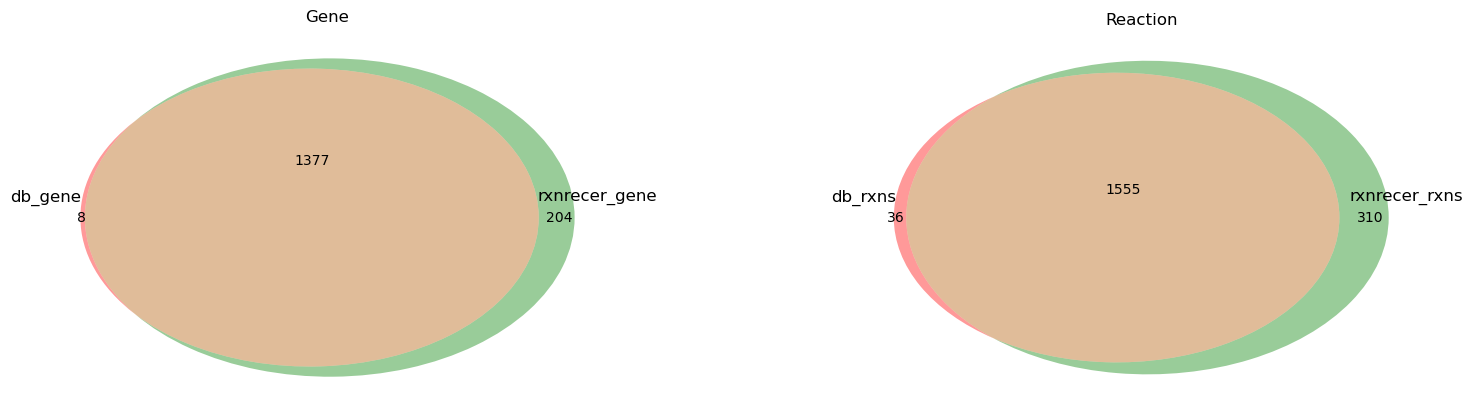

In [94]:

# 创建一个包含 1 行 2 列的子图结构
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# 第一个子图 (ax1) - gene Venn 图
plt.sca(ax1)  # 设置当前子图为 ax1
venn_diagram1 = venn2([db_gene_ids_set, rxnrecer_gene_ids_set], set_labels=('db_gene', 'rxnrecer_gene'))

# 调整第一个 Venn 图的标签位置
venn_diagram1.get_label_by_id('10').set_x(-0.55)  
venn_diagram1.get_label_by_id('01').set_x(0.55)   
venn_diagram1.get_label_by_id('11').set_y(0.2)  
venn_diagram1.get_label_by_id('A').set_position((-0.55, 0.1))  
venn_diagram1.get_label_by_id('B').set_position((0.5, 0.1))  
ax1.set_aspect(0.65)  # 调整纵横比，使图形变为椭圆

# 添加第一个子图的标题
ax1.set_title('Gene')

# 第二个子图 (ax2) - reaction Venn 图
plt.sca(ax2)  # 设置当前子图为 ax2
venn_diagram2 = venn2([db_rxn_ids_set, rxnrecer_rxn_ids_set], set_labels=('db_rxns', 'rxnrecer_rxns'))

# 调整第二个 Venn 图的标签位置
venn_diagram2.get_label_by_id('10').set_x(-0.55)  
venn_diagram2.get_label_by_id('01').set_x(0.55)   
venn_diagram2.get_label_by_id('11').set_y(0.1)  
venn_diagram2.get_label_by_id('A').set_position((-0.55, 0.1))  
venn_diagram2.get_label_by_id('B').set_position((0.5, 0.1))  

ax2.set_aspect(0.65)  # 调整纵横比，使图形变为椭圆
# 添加第二个子图的标题
ax2.set_title('Reaction')

# 调整子图布局，增加左右间距
plt.subplots_adjust(wspace=0.4)  # wspace 用来控制子图之间的水平间距

# 显示图表
plt.show()


In [95]:
db_unique_genes = db_gene_ids_set - rxnrecer_gene_ids_set

diff_genes = rlation_in_db[rlation_in_db.gene_name_bigg.isin(list(db_unique_genes))]

print(f"Number of unique genes in the database: {len(db_unique_genes)}")
print(f'Number of rxns for these unique genes: {len(set(diff_genes.id))}')

diff_genes

Number of unique genes in the database: 8
Number of rxns for these unique genes: 1


,id,name,metabolites,lower_bound,upper_bound,gene_reaction_rule,gene_name_bigg,ec_number,equation_chebi,equation_text,subsystem,notes,annotation
625,RHEA:22984,,,,,P77129,b4572,,,,,,


In [97]:
# 找出在 rxnrecer 中有但在 db 中没有的基因
rxn_unique_genes = rxnrecer_gene_ids_set - db_gene_ids_set

# 从 rlation_in_merge 中筛选出这些基因对应的反应
diff_genes = rlation_in_RNXRECer[rlation_in_RNXRECer.gene_name_bigg.isin(list(rxn_unique_genes))]

# 打印结果
print(f"Number of unique genes in the RXNRECer but not in the database: {len(rxn_unique_genes)}")
print(f'Number of rxns for these unique genes: {len(set(diff_genes.id))}')

# 输出 diff_genes
diff_genes


Number of unique genes in the RXNRECer but not in the database: 204
Number of rxns for these unique genes: 195


,id,name,metabolites,lower_bound,upper_bound,gene_reaction_rule,gene_name_bigg,ec_number,equation_chebi,equation_text,subsystem,notes,annotation
2,RHEA:10044,,"{'CHEBI:18099': -1, 'CHEBI:57540': -1, 'CHEBI:...",-1000.0,1000.0,P52037,b2902,EC:1.1.1.245,CHEBI:18099 + CHEBI:57540 = CHEBI:17854 + CHEB...,cyclohexanol + NAD(+) = cyclohexanone + H(+) +...,,,
22,RHEA:10332,,"{'CHEBI:57875': -1, 'CHEBI:58342': -1, 'CHEBI:...",-1000.0,1000.0,P32129,b3862,EC:2.3.1.62,CHEBI:57875 + CHEBI:58342 = CHEBI:57643 + CHEB...,a 2-acyl-sn-glycero-3-phosphocholine + an acyl...,,,
26,RHEA:10372,,"{'CHEBI:57287': -1, 'CHEBI:57540': -1, 'CHEBI:...",-1000.0,1000.0,P76403,b2081,EC:1.2.1.58,CHEBI:57287 + CHEBI:57540 + CHEBI:36656 = CHEB...,CoA + NAD(+) + phenylglyoxylate = benzoyl-CoA ...,,,
29,RHEA:10424,,"{'CHEBI:15377': -1, 'CHEBI:606565': -1, 'CHEBI...",-1000.0,1000.0,P29745,b1127,EC:3.5.1.32,CHEBI:15377 + CHEBI:606565 = CHEBI:16150 + CHE...,H2O + N-benzoylglycine = benzoate + glycine,,,
37,RHEA:10628,,"{'CHEBI:43474': -1, 'CHEBI:173114': 1, 'CHEBI:...",-1000.0,1000.0,P0CG19,b3643,EC:2.7.7.56,CHEBI:43474 + CHEBI:173114 = CHEBI:57930 + CHE...,phosphate + tRNA(n+1) = a ribonucleoside 5'-di...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,RHEA:74815,,"{'CHEBI:77342': -1, 'CHEBI:57379': -1, 'CHEBI:...",-1000.0,1000.0,P32129,b3862,,CHEBI:77342 + CHEBI:57379 = CHEBI:75029 + CHEB...,2-(9Z-octadecenoyl)-sn-glycero-3-phospho-L-ser...,,,
1854,RHEA:74823,,"{'CHEBI:76085': -1, 'CHEBI:57394': -1, 'CHEBI:...",-1000.0,1000.0,P32129,b3862,,CHEBI:76085 + CHEBI:57394 = CHEBI:84829 + CHEB...,"2-(4Z,7Z,10Z,13Z,16Z,19Z-docosahexaenoyl)-sn-g...",,,
1855,RHEA:75387,,"{'CHEBI:15377': -1, 'CHEBI:194371': -1, 'CHEBI...",-1000.0,1000.0,P05100,b3549,,CHEBI:15377 + CHEBI:194371 = CHEBI:78346 + CHE...,H2O + queuosine 5'-phosphate = D-ribose 5-phos...,,,
1861,RHEA:77103,,"{'CHEBI:75468': -1, 'CHEBI:15377': -1, 'CHEBI:...",-1000.0,1000.0,P75736,b0686,,CHEBI:75468 + CHEBI:15377 = CHEBI:73990 + CHEB...,1-octadecanoyl-2-(9Z-octadecenoyl)-sn-glycerol...,,,


### 4.2  对比IML1515 gene

In [98]:
# 下载模型文件
if FIRST_TIME_RUN:
    ! wget -c http://bigg.ucsd.edu/static/models/iML1515.json
    
    
with open('iML1515.json', 'r', encoding='utf-8') as f:
    iml1515 = json.load(f)
    
iml1515_gene_ids = [gene['id'] for gene in iml1515['genes']]
print(f'Gene ids in iML1515: {len(iml1515_gene_ids)}')

Gene ids in iML1515: 1516


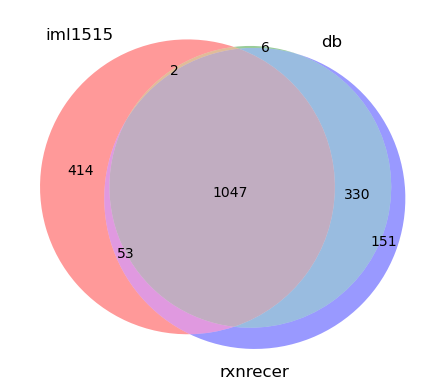

In [99]:
iml1515_gene_ids_set = set(iml1515_gene_ids)

# 绘制 3 集合的 Venn 图
venn_diagram = venn3([iml1515_gene_ids_set, db_gene_ids_set, rxnrecer_gene_ids_set], 
                     set_labels=('iml1515', 'db', 'rxnrecer'))

# 显示图表
plt.show()


In [101]:
pd.set_option('max_colwidth',100)
rlation_in_RNXRECer[rlation_in_RNXRECer.gene_name_bigg.isin(list(rxnrecer_gene_ids_set - iml1515_gene_ids_set))].to_excel('ecoli_rxnrecer_relation_without_iml1515.xlsx')

In [ ]:
list(db_gene_ids_set - iml1515_gene_ids_set)

In [103]:
db_gene_ids_set - iml1515_gene_ids_set

{'-',
 'b0026',
 'b0028',
 'b0039',
 'b0051',
 'b0053',
 'b0058',
 'b0060',
 'b0082',
 'b0143',
 'b0147',
 'b0148',
 'b0167',
 'b0184',
 'b0188',
 'b0191',
 'b0194',
 'b0195',
 'b0215',
 'b0219',
 'b0231',
 'b0239',
 'b0262',
 'b0284',
 'b0285',
 'b0286',
 'b0342',
 'b0385',
 'b0391',
 'b0405',
 'b0406',
 'b0419',
 'b0424',
 'b0436',
 'b0443',
 'b0457',
 'b0470',
 'b0503',
 'b0525',
 'b0526',
 'b0581',
 'b0599',
 'b0600',
 'b0618',
 'b0634',
 'b0636',
 'b0640',
 'b0642',
 'b0661',
 'b0680',
 'b0711',
 'b0712',
 'b0713',
 'b0714',
 'b0797',
 'b0798',
 'b0799',
 'b0801',
 'b0807',
 'b0812',
 'b0824',
 'b0833',
 'b0834',
 'b0835',
 'b0838',
 'b0859',
 'b0873',
 'b0885',
 'b0893',
 'b0921',
 'b0927',
 'b0930',
 'b0948',
 'b0949',
 'b0962',
 'b0967',
 'b0981',
 'b0982',
 'b1045',
 'b1046',
 'b1055',
 'b1066',
 'b1086',
 'b1087',
 'b1099',
 'b1120',
 'b1128',
 'b1133',
 'b1135',
 'b1168',
 'b1180',
 'b1191',
 'b1204',
 'b1212',
 'b1218',
 'b1266',
 'b1269',
 'b1309',
 'b1313',
 'b1314',
 'b1

In [104]:
iml1515_gene_ids_set - db_gene_ids_set

{'b0007',
 'b0010',
 'b0030',
 'b0047',
 'b0054',
 'b0067',
 'b0068',
 'b0070',
 'b0084',
 'b0110',
 'b0150',
 'b0151',
 'b0152',
 'b0153',
 'b0158',
 'b0197',
 'b0198',
 'b0211',
 'b0237',
 'b0241',
 'b0260',
 'b0306',
 'b0307',
 'b0308',
 'b0336',
 'b0341',
 'b0344',
 'b0365',
 'b0367',
 'b0376',
 'b0401',
 'b0402',
 'b0403',
 'b0411',
 'b0429',
 'b0430',
 'b0432',
 'b0433',
 'b0451',
 'b0462',
 'b0463',
 'b0465',
 'b0493',
 'b0543',
 'b0572',
 'b0573',
 'b0574',
 'b0575',
 'b0577',
 'b0584',
 'b0589',
 'b0590',
 'b0591',
 'b0592',
 'b0597',
 'b0604',
 'b0606',
 'b0612',
 'b0617',
 'b0635',
 'b0641',
 'b0650',
 'b0651',
 'b0653',
 'b0654',
 'b0655',
 'b0681',
 'b0684',
 'b0696',
 'b0698',
 'b0709',
 'b0721',
 'b0722',
 'b0751',
 'b0752',
 'b0763',
 'b0764',
 'b0784',
 'b0805',
 'b0808',
 'b0809',
 'b0810',
 'b0811',
 'b0813',
 'b0819',
 'b0822',
 'b0828',
 'b0830',
 'b0831',
 'b0832',
 'b0837',
 'b0839',
 'b0842',
 'b0849',
 'b0854',
 'b0856',
 'b0857',
 'b0860',
 'b0861',
 'b0862',


In [106]:
rlation_in_db.gene_name_bigg

0             b1482
1             b4214
2             b2029
3             b0507
4       b2744;b4213
           ...     
1586          b3847
1587          b0356
1588    b1246;b1247
1589          b4280
1590          b4280
Name: gene_name_bigg, Length: 1591, dtype: object

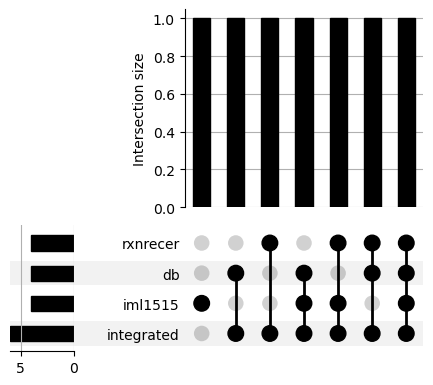

In [107]:

from upsetplot import UpSet
from collections import defaultdict

# 定义四个集合
# iml1515_gene_ids_set = set(iml1515_gene_ids)
# db_gene_ids_set = set(rlation_in_db.gene_name_bigg)
# rxnrecer_gene_ids_set = set(rlation_in_RNXRECer.gene_name_bigg)
# integrated_gene_ids_set = set(rlation_in_merge.gene_name_bigg)

# 计算交集关系
intersection_data = defaultdict(int)
all_sets = [iml1515_gene_ids_set, db_gene_ids_set, rxnrecer_gene_ids_set, integrated_gene_ids_set]

# 生成每个基因 ID 的集合组合
for gene in set.union(*all_sets):
    membership = tuple(gene in s for s in all_sets)
    intersection_data[membership] += 1

# 将结果转换为 DataFrame 并绘制 UpSet 图
df = pd.Series(intersection_data)

# 设置索引的名称为集合的名称，避免 None 重复问题
df.index.names = ['iml1515', 'db', 'rxnrecer', 'integrated']

# 绘制 UpSet 图
UpSet(df, subset_size='count').plot()

plt.show()




In [283]:
len(set(iml1515_gene_ids) & set(rlation_in_db.gene_name_bigg))

1049

In [279]:
rlation_in_merge[~rlation_in_merge.gene_name_bigg.isin(iml1515_gene_ids)]

,gene_id,gene_name_bigg,reaction_id,ec_number,equation_chebi,equation_text
7,P77766,b1266,RHEA:43532,EC:3.1.3.97,CHEBI:83402 + CHEBI:15377 = CHEBI:58043 + CHEB...,"a ribonucleoside 3',5'-bisphosphate + H2O = a ..."
37,P33644,b2593,RHEA:24408,EC:3.5.4.4,CHEBI:16335 + CHEBI:15378 + CHEBI:15377 = CHEB...,adenosine + H(+) + H2O = inosine + NH4(+)
38,P33644,b2593,RHEA:27642,EC:2.4.2.1,CHEBI:16335 + CHEBI:43474 = CHEBI:16708 + CHEB...,adenosine + phosphate = adenine + alpha-D-ribo...
39,P33644,b2593,RHEA:27646,EC:2.4.2.1,CHEBI:17596 + CHEBI:43474 = CHEBI:57720 + CHEB...,inosine + phosphate = alpha-D-ribose 1-phospha...
40,P33644,b2593,RHEA:11852,EC:2.4.2.28,CHEBI:43474 + CHEBI:17509 = CHEBI:16708 + CHEB...,phosphate + S-methyl-5'-thioadenosine = adenin...
...,...,...,...,...,...,...
2335,P52048,b4465,RHEA:19661,EC:1.1.1.17,CHEBI:61381 + CHEBI:57540 = CHEBI:57634 + CHEB...,D-mannitol 1-phosphate + NAD(+) = beta-D-fruct...
2336,P71311,b0364,RHEA:33411,None,CHEBI:64870 + CHEBI:15377 = CHEBI:64871 + CHEB...,(S)-malyl N-acetyl-alpha-D-glucosaminide + H2O...
2337,P0AAV8,b0769,RHEA:28931,EC:5.3.2.8,CHEBI:57471 = CHEBI:58142,"(1E)-4-oxobut-1-ene-1,2,4-tricarboxylate = 4-c..."
2338,K0JFS6,-,RHEA:46164,EC:1.6.5.2;EC:1.6.5.10,CHEBI:132124 + CHEBI:15378 + CHEBI:57783 = CHE...,a quinone + H(+) + NADPH = a quinol + NADP(+)


In [ ]:
case_ecoli['lb_rxn_groundtruth'] = case_ecoli.reaction_id.parallel_apply(lambda x: cmfunc.make_label(reaction_id=str(x), rxn_label_dict=dict_rxn2id)) #make label for each blast prediction
case_ecoli['lb_rxn_RXNRECer'] = case_ecoli.RXNRECer.parallel_apply(lambda x: cmfunc.make_label(reaction_id=str(x), rxn_label_dict=dict_rxn2id)) #make label for each blast prediction
metrics_rxn_enzyme = cmfunc.rxn_eva_metric(eva_df=case_ecoli, eva_name='[RXN ECOLI]', methods=['RXNRECer'])
metrics_rxn_enzyme

In [80]:
ds_train =pd.read_feather(cfg.FILE_DS_TRAIN)
uniprot_id_in_train =  case_ecoli[case_ecoli.uniprot_id.isin(ds_train.uniprot_id)].uniprot_id.tolist()

r_in_train = case_ecoli[case_ecoli.uniprot_id.isin(uniprot_id_in_train)]
mr_in_train = cmfunc.rxn_eva_metric(eva_df=r_in_train, eva_name='[RXN ECOLI]', methods=['RXNRECer'])

r_notin_train = case_ecoli[~case_ecoli.uniprot_id.isin(uniprot_id_in_train)]
mr_notin_train = cmfunc.rxn_eva_metric(eva_df=r_notin_train, eva_name='[RXN ECOLI]', methods=['RXNRECer'])


print(f'Ecoli Records:{len(case_ecoli)}')
print(f'Overall Performance：\n{metrics_rxn_enzyme}\n')


print(f'Ecoli Records appeared in training set:{len(uniprot_id_in_train)}')
print(f'Performance：\n{mr_in_train}\n')


print(f'Ecoli Records not appeared in training set:{len(r_notin_train)}')
print(f'Performance：\n{mr_notin_train}\n')

Evaluating: Reaction Predcition Results [RXN ECOLI]
Evaluating: Reaction Predcition Results [RXN ECOLI]
Ecoli Records:4481
Overall Performance：
  baselineName  mAccuracy  mPrecision   mRecall       mF1
0     RXNRECer   0.927695    0.981561  0.917729  0.928603

Ecoli Records appeared in training set:3966
Performance：
  baselineName  mAccuracy  mPrecision  mRecall       mF1
0     RXNRECer   0.962683    0.990722  0.94547  0.946426

Ecoli Records not appeared in training set:515
Performance：
  baselineName  mAccuracy  mPrecision   mRecall       mF1
0     RXNRECer   0.658252         1.0  0.669231  0.800751



In [81]:
case_ecoli[case_ecoli.lb_rxn_groundtruth != case_ecoli.lb_rxn_RXNRECer]

,uniprot_id,reviewed,protein_name,gene_names,organism_name,length,ec,reaction_id,seq,lb_rxn_groundtruth,RXNRECer,equations,equations_chebi,lb_rxn_RXNRECer
28,P31658,reviewed,Protein/nucleic acid deglycase 1 (EC 3.1.2.-) ...,hchA yedU yzzC b1967 JW1950,Escherichia coli (strain K12),283,3.1.2.-;;3.5.1.-;;3.5.1.124;;4.2.1.130,RHEA:27754;RHEA:49548;RHEA:49552;RHEA:49556;RH...,MTVQTSKNPQVDIAEDNAFFPSEYSLSQYTSPVSDLDGVDYPKPYR...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:57304;RHEA:57300;RHEA:57248;RHEA:57260;RH...,[H2O + N(2)-(1-hydroxy-2-oxoethyl)-GMP = glyco...,[CHEBI:15377 + CHEBI:141576 = CHEBI:29805 + CH...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
41,P37339,reviewed,L-2-hydroxyglutarate dehydrogenase (L2HG dehyd...,lhgD lhgO ygaF b2660 JW2635,Escherichia coli (strain K12),422,1.1.5.13,RHEA:58664,MYDFVIIGGGIIGMSTAMQLIDVYPDARIALLEKESAPACHQTGHN...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:21252,[(S)-2-hydroxyglutarate + A = 2-oxoglutarate +...,[CHEBI:16782 + CHEBI:13193 = CHEBI:16810 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
45,P37595,reviewed,Isoaspartyl peptidase (EC 3.4.19.5) (Beta-aspa...,iaaA spt ybiK b0828 JW0812,Escherichia coli (strain K12),321,3.4.19.5,-,MGKAVIAIHGGAGAISRAQMSLQQELRYIEALSAIVETGQKMLEAG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:21016,[H2O + L-asparagine = L-aspartate + NH4(+)],[CHEBI:15377 + CHEBI:58048 = CHEBI:29991 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
67,P37666,reviewed,Glyoxylate/hydroxypyruvate reductase B (EC 1.1...,ghrB tkrA yiaE b3553 JW5656,Escherichia coli (strain K12),324,1.1.1.215;;1.1.1.79;;1.1.1.81,RHEA:10992;RHEA:17905;RHEA:18657;RHEA:16653,MKPSVILYKALPDDLLQRLQEHFTVHQVANLSPQTVEQNAAIFAEA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:17905;RHEA:10992;RHEA:18657,[(R)-glycerate + NAD(+) = 3-hydroxypyruvate + ...,[CHEBI:16659 + CHEBI:57540 = CHEBI:17180 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
76,Q46857,reviewed,"2,5-diketo-D-gluconic acid reductase A (2,5-DK...",dkgA yqhE b3012 JW5499,Escherichia coli (strain K12),275,1.1.1.274,RHEA:23828,MANPTVIKLQDGNVMPQLGLGVWQASNEEVITAIQKALEVGYRSID...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:35111,"[2-dehydro-L-idonate + NADP(+) = 2,5-didehydro...",[CHEBI:36602 + CHEBI:58349 = CHEBI:11449 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4146,P76418,reviewed,Uncharacterized protein YegU (EC 3.2.2.-),yegU b2099 JW2086,Escherichia coli (strain K12),334,3.2.2.-,-,MKTERILGALYGQALGDAMGMPSELWPRSRVKAHFGWIDRFLPGPK...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:14493,[H2O + N(omega)-alpha-(ADP-D-ribosyl)-L-arginy...,[CHEBI:15377 + CHEBI:83960 = CHEBI:57967 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4312,P52048,reviewed,Uncharacterized protein YggP,yggP b4465 JW5477,Escherichia coli (strain K12),425,-,-,MKTKVAAIYGKRDVRLRVFELPEITDNELLVSVISDSVCLSTWKAA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:19661,[D-mannitol 1-phosphate + NAD(+) = beta-D-fruc...,[CHEBI:61381 + CHEBI:57540 = CHEBI:57634 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4420,P71311,reviewed,Uncharacterized deacetylase YaiS (EC 3.-.-.-),yaiS b0364 JW0356,Escherichia coli (strain K12),185,3.-.-.-,-,MDKVLDSALLSSANKRKGILAIGAHPDDIELGCGASLARLAQKGIY...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:33411,[(S)-malyl N-acetyl-alpha-D-glucosaminide + H2...,[CHEBI:64870 + CHEBI:15377 = CHEBI:64871 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4421,P0AAV8,reviewed,Putative isomerase YbhH (EC 5.-.-.-),ybhH b0769 JW0752,Escherichia coli (strain K12),350,5.-.-.-,-,MKKIPCVMMRGGTSRGAFLLAEHLPEDQTQRDKILMAIMGSGNDLE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:28931,"[(1E)-4-oxobut-1-ene-1,2,4-tricarboxylate = 4-...",[CHEBI:57471 = CHEBI:58142],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [83]:
new_findeing = case_ecoli[(case_ecoli.reaction_id=='-')&( case_ecoli.RXNRECer!='-')].reset_index(drop=True)
new_findeing

,uniprot_id,reviewed,protein_name,gene_names,organism_name,length,ec,reaction_id,seq,lb_rxn_groundtruth,RXNRECer,equations,equations_chebi,lb_rxn_RXNRECer
0,P37595,reviewed,Isoaspartyl peptidase (EC 3.4.19.5) (Beta-aspa...,iaaA spt ybiK b0828 JW0812,Escherichia coli (strain K12),321,3.4.19.5,-,MGKAVIAIHGGAGAISRAQMSLQQELRYIEALSAIVETGQKMLEAG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:21016,[H2O + L-asparagine = L-aspartate + NH4(+)],[CHEBI:15377 + CHEBI:58048 = CHEBI:29991 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,P17117,reviewed,Oxygen-insensitive NADPH nitroreductase (EC 1....,nfsA mda18 mdaA ybjB b0851 JW0835,Escherichia coli (strain K12),240,1.-.-.-,-,MTPTIELICGHRSIRHFTDEPISEAQREAIINSARATSSSSFLQCS...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:21624,[FMNH2 + NADP(+) = FMN + 2 H(+) + NADPH],[CHEBI:57618 + CHEBI:58349 = CHEBI:58210 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,P23872,reviewed,Acetyl esterase (EC 3.1.1.-) (EcE),aes ybaC b0476 JW0465,Escherichia coli (strain K12),319,3.1.1.-,-,MKPENKLPVLDLISAEMKTVVNTLQPDLPPWPATGTIAEQRQYYTL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:21164,[a carboxylic ester + H2O = a carboxylate + an...,[CHEBI:33308 + CHEBI:15377 = CHEBI:29067 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,P0A8V0,reviewed,Ribonuclease BN (RNase BN) (EC 3.1.-.-) (Ribon...,rbn elaC rnz b2268 JW2263,Escherichia coli (strain K12),305,3.1.-.-,-,MELIFLGTSAGVPTRTRNVTAILLNLQHPTQSGLWLFDCGEGTQHQ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:10748,[H(+) + hydrogencarbonate = CO2 + H2O],[CHEBI:15378 + CHEBI:17544 = CHEBI:16526 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,P75792,reviewed,Sugar phosphatase YbiV (EC 3.1.3.23),ybiV supH b0822 JW0806,Escherichia coli (strain K12),271,3.1.3.23,-,MSVKVIVTDMDGTFLNDAKTYNQPRFMAQYQELKKRGIKFVVASGN...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:25197,[5-amino-6-(5-phospho-D-ribitylamino)uracil + ...,[CHEBI:58421 + CHEBI:15377 = CHEBI:15934 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,P76418,reviewed,Uncharacterized protein YegU (EC 3.2.2.-),yegU b2099 JW2086,Escherichia coli (strain K12),334,3.2.2.-,-,MKTERILGALYGQALGDAMGMPSELWPRSRVKAHFGWIDRFLPGPK...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:14493,[H2O + N(omega)-alpha-(ADP-D-ribosyl)-L-arginy...,[CHEBI:15377 + CHEBI:83960 = CHEBI:57967 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
183,P52048,reviewed,Uncharacterized protein YggP,yggP b4465 JW5477,Escherichia coli (strain K12),425,-,-,MKTKVAAIYGKRDVRLRVFELPEITDNELLVSVISDSVCLSTWKAA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:19661,[D-mannitol 1-phosphate + NAD(+) = beta-D-fruc...,[CHEBI:61381 + CHEBI:57540 = CHEBI:57634 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
184,P71311,reviewed,Uncharacterized deacetylase YaiS (EC 3.-.-.-),yaiS b0364 JW0356,Escherichia coli (strain K12),185,3.-.-.-,-,MDKVLDSALLSSANKRKGILAIGAHPDDIELGCGASLARLAQKGIY...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:33411,[(S)-malyl N-acetyl-alpha-D-glucosaminide + H2...,[CHEBI:64870 + CHEBI:15377 = CHEBI:64871 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
185,P0AAV8,reviewed,Putative isomerase YbhH (EC 5.-.-.-),ybhH b0769 JW0752,Escherichia coli (strain K12),350,5.-.-.-,-,MKKIPCVMMRGGTSRGAFLLAEHLPEDQTQRDKILMAIMGSGNDLE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:28931,"[(1E)-4-oxobut-1-ene-1,2,4-tricarboxylate = 4-...",[CHEBI:57471 = CHEBI:58142],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [22]:
ds_rxn = pd.read_feather(cfg.FILE_DS_RHEA_REACTIONS)

In [25]:
ds_rxn.to_feather(cfg.FILE_DS_RHEA_REACTIONS)

In [21]:
new_findeing

,uniprot_id,reviewed,protein_name,gene_names,organism_name,length,ec,reaction_id,seq,RXNRECer,lb_rxn_groundtruth,lb_rxn_RXNRECer
0,P37595,reviewed,Isoaspartyl peptidase (EC 3.4.19.5) (Beta-aspa...,iaaA spt ybiK b0828 JW0812,Escherichia coli (strain K12),321,3.4.19.5,-,MGKAVIAIHGGAGAISRAQMSLQQELRYIEALSAIVETGQKMLEAG...,RHEA:21016,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,P17117,reviewed,Oxygen-insensitive NADPH nitroreductase (EC 1....,nfsA mda18 mdaA ybjB b0851 JW0835,Escherichia coli (strain K12),240,1.-.-.-,-,MTPTIELICGHRSIRHFTDEPISEAQREAIINSARATSSSSFLQCS...,RHEA:21624,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,P23872,reviewed,Acetyl esterase (EC 3.1.1.-) (EcE),aes ybaC b0476 JW0465,Escherichia coli (strain K12),319,3.1.1.-,-,MKPENKLPVLDLISAEMKTVVNTLQPDLPPWPATGTIAEQRQYYTL...,RHEA:21164,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,P0A8V0,reviewed,Ribonuclease BN (RNase BN) (EC 3.1.-.-) (Ribon...,rbn elaC rnz b2268 JW2263,Escherichia coli (strain K12),305,3.1.-.-,-,MELIFLGTSAGVPTRTRNVTAILLNLQHPTQSGLWLFDCGEGTQHQ...,RHEA:10748,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,P75792,reviewed,Sugar phosphatase YbiV (EC 3.1.3.23),ybiV supH b0822 JW0806,Escherichia coli (strain K12),271,3.1.3.23,-,MSVKVIVTDMDGTFLNDAKTYNQPRFMAQYQELKKRGIKFVVASGN...,RHEA:25197,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
182,P76418,reviewed,Uncharacterized protein YegU (EC 3.2.2.-),yegU b2099 JW2086,Escherichia coli (strain K12),334,3.2.2.-,-,MKTERILGALYGQALGDAMGMPSELWPRSRVKAHFGWIDRFLPGPK...,RHEA:14493,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
183,P52048,reviewed,Uncharacterized protein YggP,yggP b4465 JW5477,Escherichia coli (strain K12),425,-,-,MKTKVAAIYGKRDVRLRVFELPEITDNELLVSVISDSVCLSTWKAA...,RHEA:19661,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
184,P71311,reviewed,Uncharacterized deacetylase YaiS (EC 3.-.-.-),yaiS b0364 JW0356,Escherichia coli (strain K12),185,3.-.-.-,-,MDKVLDSALLSSANKRKGILAIGAHPDDIELGCGASLARLAQKGIY...,RHEA:33411,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
185,P0AAV8,reviewed,Putative isomerase YbhH (EC 5.-.-.-),ybhH b0769 JW0752,Escherichia coli (strain K12),350,5.-.-.-,-,MKKIPCVMMRGGTSRGAFLLAEHLPEDQTQRDKILMAIMGSGNDLE...,RHEA:28931,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
